In [1]:
!pip install -q torchsummary

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split
from torchsummary import summary
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import OneCycleLR
import time

In [2]:
# KANLinear class definition as provided
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, scale_noise=0.1, scale_base=1.0, scale_spline=1.0, enable_standalone_scale_spline=True, base_activation=nn.SiLU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)
        splines = self.b_splines(x).permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff).permute(1, 0, 2)
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[torch.linspace(0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device)]
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (torch.arange(self.grid_size + 1, dtype=torch.float32, device=x.device).unsqueeze(1) * uniform_step + x_sorted[0] - margin)
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat([grid[:1] - uniform_step * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1), grid, grid[-1:] + uniform_step * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1)], dim=0)
        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy



## Kode versi terbaru ini ditambahkan batch_normalisasi pada setiap akhir layer conv

1. Stabilisasi Distribusi Aktivasi:

Batch Normalization menstabilkan distribusi aktivasi jaringan dengan menormalkan output dari setiap layer berdasarkan mini-batch.
Ini membantu mengurangi masalah "vanishing gradients" (gradien menghilang) dan "exploding gradients" (gradien meledak), yang sering menjadi kendala dalam pelatihan jaringan yang dalam.

2. Akselerasi Konvergensi:

Dengan menormalkan input di setiap lapisan, model dapat menggunakan tingkat pembelajaran yang lebih tinggi tanpa takut terjebak dalam lokal minima atau divergen.
Hal ini mempercepat proses pelatihan karena model lebih cepat menemukan optimal point.

3. Regularisasi Implisit:

Batch Normalization menambahkan sedikit noise pada setiap mini-batch selama pelatihan, yang bertindak sebagai regularizer dan membantu mencegah overfitting.
Ini membuat model lebih generalizable ke data yang belum pernah dilihat sebelumnya.

4. Mengurangi Ketergantungan pada Inisialisasi Parameter:

Model menjadi lebih robust terhadap inisialisasi parameter yang buruk karena Batch Normalization mengontrol skala aktivasi.
Ini memungkinkan penggunaan berbagai skema inisialisasi tanpa kehilangan performa.

5. Mengurangi Sensitivitas terhadap Skala Input:

Dengan menormalkan data dalam mini-batch, Batch Normalization mengurangi sensitivitas model terhadap skala dan distribusi input awal.
Ini membantu dalam situasi di mana data memiliki berbagai macam skala dan distribusi.

In [3]:
class VGG19(nn.Module):
    def __init__(self, num_classes=100):  # Default is for ImageNet
        super(VGG19, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inpl

100%|██████████| 169001437/169001437 [00:06<00:00, 24225660.35it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Train Epoch: 0 [0/50000 (0%)]	Loss: 4.642334
Train Epoch: 0 [640/50000 (2%)]	Loss: 4.598187
Train Epoch: 0 [1280/50000 (3%)]	Loss: 4.545225
Train Epoch: 0 [1920/50000 (5%)]	Loss: 4.568428
Train Epoch: 0 [2560/50000 (6%)]	Loss: 4.614418
Train Epoch: 0 [3200/50000 (8%)]	Loss: 4.582316
Train Epoch: 0 [3840/50000 (10%)]	Loss: 4.577160
Train Epoch: 0 [4480/50000 (11%)]	Loss: 4.562413
Train Epoch: 0 [5120/50000 (13%)]	Loss: 4.604184
Train Epoch: 0 [5760/50000 (14%)]	Loss: 4.554276
Train Epoch: 0 [6400/50000 (16%)]	Loss: 4.644413
Train Epoch: 0 [7040/50000 (18%)]	Loss: 4.396534
Train Epoch: 0 [7680/50000 (19%)]	Loss: 4.364849
Train Epoch: 0 [8320/50000 (21%)]	Loss: 4.492888
Train Epoch: 0 [8960/50000 (22%)]	Loss: 4.397742
Train Epoch: 0 [9600/50000 (24%)]	Loss: 4.479237
Train Epoch: 0 [10240/50000 (26%)]	Loss: 4.311706
Train Epoch: 0 [10880/50000 (27%)]	Loss: 4.465405
Train Epoch: 0 [11520/50000 (29%)]	L

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.22      0.05      0.08       100
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.00      0.00      0.00       100
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       100
           8       0.00      0.00      0.00       100
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00       100
          11       0.03      0.11      0.05       100
          12       0.09      0.04      0.06       100
          13       0.20      0.01      0.02       100
          14       0.09      0.11      0.10       100
          15       0.00      0.00      0.00       100
          16       0.00      0.00      0.00       100
          17       0.14    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

Train Epoch: 2 [0/50000 (0%)]	Loss: 3.618359
Train Epoch: 2 [640/50000 (2%)]	Loss: 3.967689
Train Epoch: 2 [1280/50000 (3%)]	Loss: 3.659977
Train Epoch: 2 [1920/50000 (5%)]	Loss: 3.573046
Train Epoch: 2 [2560/50000 (6%)]	Loss: 3.728354
Train Epoch: 2 [3200/50000 (8%)]	Loss: 3.585629
Train Epoch: 2 [3840/50000 (10%)]	Loss: 3.521522
Train Epoch: 2 [4480/50000 (11%)]	Loss: 3.873004
Train Epoch: 2 [5120/50000 (13%)]	Loss: 3.957996
Train Epoch: 2 [5760/50000 (14%)]	Loss: 3.866554
Train Epoch: 2 [6400/50000 (16%)]	Loss: 3.448611
Train Epoch: 2 [7040/50000 (18%)]	Loss: 3.746918
Train Epoch: 2 [7680/50000 (19%)]	Loss: 3.744410
Train Epoch: 2 [8320/50000 (21%)]	Loss: 3.660621
Train Epoch: 2 [8960/50000 (22%)]	Loss: 3.629005
Train Epoch: 2 [9600/50000 (24%)]	Loss: 3.499208
Train Epoch: 2 [10240/50000 (26%)]	Loss: 3.546375
Train Epoch: 2 [10880/50000 (27%)]	Loss: 3.659095
Train Epoch: 2 [11520/50000 (29%)]	Loss: 3.840986
Train Epoch: 2 [12160/50000 (30%)]	Loss: 3.761650
Train Epoch: 2 [12800/5000

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

Train Epoch: 3 [0/50000 (0%)]	Loss: 3.514494
Train Epoch: 3 [640/50000 (2%)]	Loss: 3.580860
Train Epoch: 3 [1280/50000 (3%)]	Loss: 3.779197
Train Epoch: 3 [1920/50000 (5%)]	Loss: 3.384534
Train Epoch: 3 [2560/50000 (6%)]	Loss: 3.541350
Train Epoch: 3 [3200/50000 (8%)]	Loss: 3.514660
Train Epoch: 3 [3840/50000 (10%)]	Loss: 3.738423
Train Epoch: 3 [4480/50000 (11%)]	Loss: 3.779050
Train Epoch: 3 [5120/50000 (13%)]	Loss: 3.614055
Train Epoch: 3 [5760/50000 (14%)]	Loss: 3.558819
Train Epoch: 3 [6400/50000 (16%)]	Loss: 3.878083
Train Epoch: 3 [7040/50000 (18%)]	Loss: 3.674973
Train Epoch: 3 [7680/50000 (19%)]	Loss: 3.593055
Train Epoch: 3 [8320/50000 (21%)]	Loss: 3.757683
Train Epoch: 3 [8960/50000 (22%)]	Loss: 3.813297
Train Epoch: 3 [9600/50000 (24%)]	Loss: 3.464799
Train Epoch: 3 [10240/50000 (26%)]	Loss: 3.714194
Train Epoch: 3 [10880/50000 (27%)]	Loss: 3.747739
Train Epoch: 3 [11520/50000 (29%)]	Loss: 3.516798
Train Epoch: 3 [12160/50000 (30%)]	Loss: 3.434313
Train Epoch: 3 [12800/5000

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

Train Epoch: 4 [0/50000 (0%)]	Loss: 3.589089
Train Epoch: 4 [640/50000 (2%)]	Loss: 3.439894
Train Epoch: 4 [1280/50000 (3%)]	Loss: 3.635369
Train Epoch: 4 [1920/50000 (5%)]	Loss: 3.690924
Train Epoch: 4 [2560/50000 (6%)]	Loss: 3.647818
Train Epoch: 4 [3200/50000 (8%)]	Loss: 3.468142
Train Epoch: 4 [3840/50000 (10%)]	Loss: 3.525221
Train Epoch: 4 [4480/50000 (11%)]	Loss: 3.311528
Train Epoch: 4 [5120/50000 (13%)]	Loss: 3.438223
Train Epoch: 4 [5760/50000 (14%)]	Loss: 3.551210
Train Epoch: 4 [6400/50000 (16%)]	Loss: 3.661622
Train Epoch: 4 [7040/50000 (18%)]	Loss: 3.582560
Train Epoch: 4 [7680/50000 (19%)]	Loss: 3.683301
Train Epoch: 4 [8320/50000 (21%)]	Loss: 3.495821
Train Epoch: 4 [8960/50000 (22%)]	Loss: 3.517911
Train Epoch: 4 [9600/50000 (24%)]	Loss: 3.259822
Train Epoch: 4 [10240/50000 (26%)]	Loss: 3.581368
Train Epoch: 4 [10880/50000 (27%)]	Loss: 3.542791
Train Epoch: 4 [11520/50000 (29%)]	Loss: 3.564557
Train Epoch: 4 [12160/50000 (30%)]	Loss: 3.439733
Train Epoch: 4 [12800/5000

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.32      0.34      0.33       100
           1       0.14      0.14      0.14       100
           2       0.16      0.05      0.08       100
           3       0.10      0.03      0.05       100
           4       0.08      0.04      0.05       100
           5       0.09      0.10      0.09       100
           6       0.16      0.04      0.06       100
           7       0.12      0.11      0.12       100
           8       0.08      0.23      0.12       100
           9       0.24      0.07      0.11       100
          10       0.00      0.00      0.00       100
          11       0.16      0.05      0.08       100
          12       0.17      0.15      0.16       100
          13       0.17      0.28      0.22       100
          14       0.15      0.11      0.13       100
          15       0.00      0.00      0.00       100
          16       0.12      0.09      0.10       100
          17       0.25    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

Train Epoch: 6 [0/50000 (0%)]	Loss: 3.844450
Train Epoch: 6 [640/50000 (2%)]	Loss: 3.595061
Train Epoch: 6 [1280/50000 (3%)]	Loss: 3.633791
Train Epoch: 6 [1920/50000 (5%)]	Loss: 3.469042
Train Epoch: 6 [2560/50000 (6%)]	Loss: 3.259844
Train Epoch: 6 [3200/50000 (8%)]	Loss: 3.318262
Train Epoch: 6 [3840/50000 (10%)]	Loss: 3.358771
Train Epoch: 6 [4480/50000 (11%)]	Loss: 3.237058
Train Epoch: 6 [5120/50000 (13%)]	Loss: 3.129708
Train Epoch: 6 [5760/50000 (14%)]	Loss: 3.637343
Train Epoch: 6 [6400/50000 (16%)]	Loss: 3.094734
Train Epoch: 6 [7040/50000 (18%)]	Loss: 3.258745
Train Epoch: 6 [7680/50000 (19%)]	Loss: 3.315260
Train Epoch: 6 [8320/50000 (21%)]	Loss: 3.269430
Train Epoch: 6 [8960/50000 (22%)]	Loss: 3.444721
Train Epoch: 6 [9600/50000 (24%)]	Loss: 3.748698
Train Epoch: 6 [10240/50000 (26%)]	Loss: 3.669228
Train Epoch: 6 [10880/50000 (27%)]	Loss: 3.293812
Train Epoch: 6 [11520/50000 (29%)]	Loss: 3.180745
Train Epoch: 6 [12160/50000 (30%)]	Loss: 3.397564
Train Epoch: 6 [12800/5000

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

Train Epoch: 7 [0/50000 (0%)]	Loss: 3.451156
Train Epoch: 7 [640/50000 (2%)]	Loss: 3.395473
Train Epoch: 7 [1280/50000 (3%)]	Loss: 3.295198
Train Epoch: 7 [1920/50000 (5%)]	Loss: 3.314235
Train Epoch: 7 [2560/50000 (6%)]	Loss: 3.258795
Train Epoch: 7 [3200/50000 (8%)]	Loss: 3.071863
Train Epoch: 7 [3840/50000 (10%)]	Loss: 3.134133
Train Epoch: 7 [4480/50000 (11%)]	Loss: 3.187477
Train Epoch: 7 [5120/50000 (13%)]	Loss: 3.355240
Train Epoch: 7 [5760/50000 (14%)]	Loss: 3.108436
Train Epoch: 7 [6400/50000 (16%)]	Loss: 3.412933
Train Epoch: 7 [7040/50000 (18%)]	Loss: 3.314093
Train Epoch: 7 [7680/50000 (19%)]	Loss: 3.234998
Train Epoch: 7 [8320/50000 (21%)]	Loss: 3.472273
Train Epoch: 7 [8960/50000 (22%)]	Loss: 3.264285
Train Epoch: 7 [9600/50000 (24%)]	Loss: 2.937132
Train Epoch: 7 [10240/50000 (26%)]	Loss: 3.511353
Train Epoch: 7 [10880/50000 (27%)]	Loss: 3.121633
Train Epoch: 7 [11520/50000 (29%)]	Loss: 3.066074
Train Epoch: 7 [12160/50000 (30%)]	Loss: 2.988302
Train Epoch: 7 [12800/5000

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 8 [0/50000 (0%)]	Loss: 3.162092
Train Epoch: 8 [640/50000 (2%)]	Loss: 3.212680
Train Epoch: 8 [1280/50000 (3%)]	Loss: 3.285674
Train Epoch: 8 [1920/50000 (5%)]	Loss: 3.357342
Train Epoch: 8 [2560/50000 (6%)]	Loss: 3.085310
Train Epoch: 8 [3200/50000 (8%)]	Loss: 2.941537
Train Epoch: 8 [3840/50000 (10%)]	Loss: 3.200244
Train Epoch: 8 [4480/50000 (11%)]	Loss: 3.072239
Train Epoch: 8 [5120/50000 (13%)]	Loss: 2.909672
Train Epoch: 8 [5760/50000 (14%)]	Loss: 3.316784
Train Epoch: 8 [6400/50000 (16%)]	Loss: 3.266500
Train Epoch: 8 [7040/50000 (18%)]	Loss: 3.190993
Train Epoch: 8 [7680/50000 (19%)]	Loss: 3.157376
Train Epoch: 8 [8320/50000 (21%)]	Loss: 2.873981
Train Epoch: 8 [8960/50000 (22%)]	Loss: 3.292737
Train Epoch: 8 [9600/50000 (24%)]	Loss: 3.322060
Train Epoch: 8 [10240/50000 (26%)]	Loss: 3.235367
Train Epoch: 8 [10880/50000 (27%)]	Loss: 3.296141
Train Epoch: 8 [11520/50000 (29%)]	Loss: 3.320379
Train Epoch: 8 [12160/50000 (30%)]	Loss: 3.272459
Train Epoch: 8 [12800/5000

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

              precision    recall  f1-score   support

           0       0.28      0.48      0.36       100
           1       0.19      0.16      0.17       100
           2       0.10      0.08      0.09       100
           3       0.09      0.08      0.09       100
           4       0.08      0.13      0.10       100
           5       0.12      0.06      0.08       100
           6       0.20      0.16      0.18       100
           7       0.40      0.19      0.26       100
           8       0.29      0.07      0.11       100
           9       0.23      0.29      0.26       100
          10       0.06      0.01      0.02       100
          11       0.09      0.01      0.02       100
          12       0.28      0.16      0.20       100
          13       0.24      0.13      0.17       100
          14       0.13      0.08      0.10       100
          15       0.11      0.15      0.12       100
          16       0.24      0.07      0.11       100
          17       0.32    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

Train Epoch: 10 [0/50000 (0%)]	Loss: 3.224978
Train Epoch: 10 [640/50000 (2%)]	Loss: 2.835405
Train Epoch: 10 [1280/50000 (3%)]	Loss: 2.914428
Train Epoch: 10 [1920/50000 (5%)]	Loss: 2.756743
Train Epoch: 10 [2560/50000 (6%)]	Loss: 3.002173
Train Epoch: 10 [3200/50000 (8%)]	Loss: 2.936460
Train Epoch: 10 [3840/50000 (10%)]	Loss: 2.754402
Train Epoch: 10 [4480/50000 (11%)]	Loss: 2.998493
Train Epoch: 10 [5120/50000 (13%)]	Loss: 3.126652
Train Epoch: 10 [5760/50000 (14%)]	Loss: 2.950654
Train Epoch: 10 [6400/50000 (16%)]	Loss: 3.154634
Train Epoch: 10 [7040/50000 (18%)]	Loss: 3.025604
Train Epoch: 10 [7680/50000 (19%)]	Loss: 3.099056
Train Epoch: 10 [8320/50000 (21%)]	Loss: 3.143773
Train Epoch: 10 [8960/50000 (22%)]	Loss: 3.157835
Train Epoch: 10 [9600/50000 (24%)]	Loss: 2.860805
Train Epoch: 10 [10240/50000 (26%)]	Loss: 3.278783
Train Epoch: 10 [10880/50000 (27%)]	Loss: 2.967798
Train Epoch: 10 [11520/50000 (29%)]	Loss: 3.123016
Train Epoch: 10 [12160/50000 (30%)]	Loss: 2.938447
Train 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

Train Epoch: 11 [0/50000 (0%)]	Loss: 2.960099
Train Epoch: 11 [640/50000 (2%)]	Loss: 3.224854
Train Epoch: 11 [1280/50000 (3%)]	Loss: 3.048892
Train Epoch: 11 [1920/50000 (5%)]	Loss: 3.082292
Train Epoch: 11 [2560/50000 (6%)]	Loss: 3.241356
Train Epoch: 11 [3200/50000 (8%)]	Loss: 3.518097
Train Epoch: 11 [3840/50000 (10%)]	Loss: 2.894255
Train Epoch: 11 [4480/50000 (11%)]	Loss: 2.782765
Train Epoch: 11 [5120/50000 (13%)]	Loss: 2.737091
Train Epoch: 11 [5760/50000 (14%)]	Loss: 3.116777
Train Epoch: 11 [6400/50000 (16%)]	Loss: 2.958189
Train Epoch: 11 [7040/50000 (18%)]	Loss: 2.722181
Train Epoch: 11 [7680/50000 (19%)]	Loss: 2.987357
Train Epoch: 11 [8320/50000 (21%)]	Loss: 3.194158
Train Epoch: 11 [8960/50000 (22%)]	Loss: 2.968320
Train Epoch: 11 [9600/50000 (24%)]	Loss: 2.726209
Train Epoch: 11 [10240/50000 (26%)]	Loss: 3.117881
Train Epoch: 11 [10880/50000 (27%)]	Loss: 3.213276
Train Epoch: 11 [11520/50000 (29%)]	Loss: 3.121176
Train Epoch: 11 [12160/50000 (30%)]	Loss: 3.042221
Train 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

Train Epoch: 12 [0/50000 (0%)]	Loss: 2.863425
Train Epoch: 12 [640/50000 (2%)]	Loss: 2.969549
Train Epoch: 12 [1280/50000 (3%)]	Loss: 2.820924
Train Epoch: 12 [1920/50000 (5%)]	Loss: 3.252690
Train Epoch: 12 [2560/50000 (6%)]	Loss: 2.942139
Train Epoch: 12 [3200/50000 (8%)]	Loss: 2.834642
Train Epoch: 12 [3840/50000 (10%)]	Loss: 2.872320
Train Epoch: 12 [4480/50000 (11%)]	Loss: 2.686470
Train Epoch: 12 [5120/50000 (13%)]	Loss: 3.286180
Train Epoch: 12 [5760/50000 (14%)]	Loss: 2.893344
Train Epoch: 12 [6400/50000 (16%)]	Loss: 2.943155
Train Epoch: 12 [7040/50000 (18%)]	Loss: 2.837545
Train Epoch: 12 [7680/50000 (19%)]	Loss: 2.797249
Train Epoch: 12 [8320/50000 (21%)]	Loss: 3.094568
Train Epoch: 12 [8960/50000 (22%)]	Loss: 2.999206
Train Epoch: 12 [9600/50000 (24%)]	Loss: 3.035083
Train Epoch: 12 [10240/50000 (26%)]	Loss: 2.848013
Train Epoch: 12 [10880/50000 (27%)]	Loss: 3.057437
Train Epoch: 12 [11520/50000 (29%)]	Loss: 2.947112
Train Epoch: 12 [12160/50000 (30%)]	Loss: 2.875733
Train 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

Train Epoch: 13 [0/50000 (0%)]	Loss: 2.956629
Train Epoch: 13 [640/50000 (2%)]	Loss: 3.038917
Train Epoch: 13 [1280/50000 (3%)]	Loss: 2.818902
Train Epoch: 13 [1920/50000 (5%)]	Loss: 2.724870
Train Epoch: 13 [2560/50000 (6%)]	Loss: 2.750680
Train Epoch: 13 [3200/50000 (8%)]	Loss: 2.901968
Train Epoch: 13 [3840/50000 (10%)]	Loss: 2.794502
Train Epoch: 13 [4480/50000 (11%)]	Loss: 2.860871
Train Epoch: 13 [5120/50000 (13%)]	Loss: 3.138210
Train Epoch: 13 [5760/50000 (14%)]	Loss: 3.116762
Train Epoch: 13 [6400/50000 (16%)]	Loss: 3.024539
Train Epoch: 13 [7040/50000 (18%)]	Loss: 2.984256
Train Epoch: 13 [7680/50000 (19%)]	Loss: 2.942351
Train Epoch: 13 [8320/50000 (21%)]	Loss: 2.908404
Train Epoch: 13 [8960/50000 (22%)]	Loss: 3.143319
Train Epoch: 13 [9600/50000 (24%)]	Loss: 2.985493
Train Epoch: 13 [10240/50000 (26%)]	Loss: 2.704804
Train Epoch: 13 [10880/50000 (27%)]	Loss: 3.421962
Train Epoch: 13 [11520/50000 (29%)]	Loss: 2.860578
Train Epoch: 13 [12160/50000 (30%)]	Loss: 3.352388
Train 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

Train Epoch: 14 [0/50000 (0%)]	Loss: 3.126849
Train Epoch: 14 [640/50000 (2%)]	Loss: 2.922262
Train Epoch: 14 [1280/50000 (3%)]	Loss: 2.574515
Train Epoch: 14 [1920/50000 (5%)]	Loss: 2.519279
Train Epoch: 14 [2560/50000 (6%)]	Loss: 2.705363
Train Epoch: 14 [3200/50000 (8%)]	Loss: 2.906074
Train Epoch: 14 [3840/50000 (10%)]	Loss: 3.224790
Train Epoch: 14 [4480/50000 (11%)]	Loss: 2.516076
Train Epoch: 14 [5120/50000 (13%)]	Loss: 3.004735
Train Epoch: 14 [5760/50000 (14%)]	Loss: 2.865201
Train Epoch: 14 [6400/50000 (16%)]	Loss: 3.069101
Train Epoch: 14 [7040/50000 (18%)]	Loss: 2.513654
Train Epoch: 14 [7680/50000 (19%)]	Loss: 2.751683
Train Epoch: 14 [8320/50000 (21%)]	Loss: 3.346128
Train Epoch: 14 [8960/50000 (22%)]	Loss: 2.599604
Train Epoch: 14 [9600/50000 (24%)]	Loss: 2.822773
Train Epoch: 14 [10240/50000 (26%)]	Loss: 3.100915
Train Epoch: 14 [10880/50000 (27%)]	Loss: 2.882051
Train Epoch: 14 [11520/50000 (29%)]	Loss: 2.851904
Train Epoch: 14 [12160/50000 (30%)]	Loss: 2.795760
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 15 [0/50000 (0%)]	Loss: 2.620100
Train Epoch: 15 [640/50000 (2%)]	Loss: 2.698735
Train Epoch: 15 [1280/50000 (3%)]	Loss: 2.803696
Train Epoch: 15 [1920/50000 (5%)]	Loss: 2.652648
Train Epoch: 15 [2560/50000 (6%)]	Loss: 3.253259
Train Epoch: 15 [3200/50000 (8%)]	Loss: 2.639078
Train Epoch: 15 [3840/50000 (10%)]	Loss: 2.815813
Train Epoch: 15 [4480/50000 (11%)]	Loss: 2.807555
Train Epoch: 15 [5120/50000 (13%)]	Loss: 2.920455
Train Epoch: 15 [5760/50000 (14%)]	Loss: 2.725169
Train Epoch: 15 [6400/50000 (16%)]	Loss: 2.993705
Train Epoch: 15 [7040/50000 (18%)]	Loss: 3.480358
Train Epoch: 15 [7680/50000 (19%)]	Loss: 2.895125
Train Epoch: 15 [8320/50000 (21%)]	Loss: 3.085250
Train Epoch: 15 [8960/50000 (22%)]	Loss: 2.874984
Train Epoch: 15 [9600/50000 (24%)]	Loss: 2.892235
Train Epoch: 15 [10240/50000 (26%)]	Loss: 2.610101
Train Epoch: 15 [10880/50000 (27%)]	Loss: 2.788674
Train Epoch: 15 [11520/50000 (29%)]	Loss: 2.622083
Train Epoch: 15 [12160/50000 (30%)]	Loss: 3.045553
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 16 [0/50000 (0%)]	Loss: 2.709831
Train Epoch: 16 [640/50000 (2%)]	Loss: 2.798740
Train Epoch: 16 [1280/50000 (3%)]	Loss: 2.717851
Train Epoch: 16 [1920/50000 (5%)]	Loss: 2.640659
Train Epoch: 16 [2560/50000 (6%)]	Loss: 2.725469
Train Epoch: 16 [3200/50000 (8%)]	Loss: 2.964830
Train Epoch: 16 [3840/50000 (10%)]	Loss: 2.831976
Train Epoch: 16 [4480/50000 (11%)]	Loss: 3.190988
Train Epoch: 16 [5120/50000 (13%)]	Loss: 2.850769
Train Epoch: 16 [5760/50000 (14%)]	Loss: 2.434140
Train Epoch: 16 [6400/50000 (16%)]	Loss: 2.773179
Train Epoch: 16 [7040/50000 (18%)]	Loss: 2.968278
Train Epoch: 16 [7680/50000 (19%)]	Loss: 2.834949
Train Epoch: 16 [8320/50000 (21%)]	Loss: 3.081840
Train Epoch: 16 [8960/50000 (22%)]	Loss: 3.185615
Train Epoch: 16 [9600/50000 (24%)]	Loss: 2.759756
Train Epoch: 16 [10240/50000 (26%)]	Loss: 3.030999
Train Epoch: 16 [10880/50000 (27%)]	Loss: 2.890625
Train Epoch: 16 [11520/50000 (29%)]	Loss: 2.604978
Train Epoch: 16 [12160/50000 (30%)]	Loss: 2.334194
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 17 [0/50000 (0%)]	Loss: 3.256451
Train Epoch: 17 [640/50000 (2%)]	Loss: 2.689319
Train Epoch: 17 [1280/50000 (3%)]	Loss: 2.605900
Train Epoch: 17 [1920/50000 (5%)]	Loss: 2.585140
Train Epoch: 17 [2560/50000 (6%)]	Loss: 2.906065
Train Epoch: 17 [3200/50000 (8%)]	Loss: 2.623544
Train Epoch: 17 [3840/50000 (10%)]	Loss: 2.833712
Train Epoch: 17 [4480/50000 (11%)]	Loss: 2.615200
Train Epoch: 17 [5120/50000 (13%)]	Loss: 3.388366
Train Epoch: 17 [5760/50000 (14%)]	Loss: 2.512321
Train Epoch: 17 [6400/50000 (16%)]	Loss: 2.926759
Train Epoch: 17 [7040/50000 (18%)]	Loss: 2.698139
Train Epoch: 17 [7680/50000 (19%)]	Loss: 2.528591
Train Epoch: 17 [8320/50000 (21%)]	Loss: 2.734551
Train Epoch: 17 [8960/50000 (22%)]	Loss: 2.997901
Train Epoch: 17 [9600/50000 (24%)]	Loss: 2.790689
Train Epoch: 17 [10240/50000 (26%)]	Loss: 2.478445
Train Epoch: 17 [10880/50000 (27%)]	Loss: 2.582911
Train Epoch: 17 [11520/50000 (29%)]	Loss: 2.408243
Train Epoch: 17 [12160/50000 (30%)]	Loss: 2.743794
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 18 [0/50000 (0%)]	Loss: 2.561473
Train Epoch: 18 [640/50000 (2%)]	Loss: 2.291170
Train Epoch: 18 [1280/50000 (3%)]	Loss: 2.740948
Train Epoch: 18 [1920/50000 (5%)]	Loss: 2.799237
Train Epoch: 18 [2560/50000 (6%)]	Loss: 2.514070
Train Epoch: 18 [3200/50000 (8%)]	Loss: 2.692380
Train Epoch: 18 [3840/50000 (10%)]	Loss: 2.895997
Train Epoch: 18 [4480/50000 (11%)]	Loss: 2.604990
Train Epoch: 18 [5120/50000 (13%)]	Loss: 2.574411
Train Epoch: 18 [5760/50000 (14%)]	Loss: 2.377553
Train Epoch: 18 [6400/50000 (16%)]	Loss: 2.250206
Train Epoch: 18 [7040/50000 (18%)]	Loss: 2.649220
Train Epoch: 18 [7680/50000 (19%)]	Loss: 1.885006
Train Epoch: 18 [8320/50000 (21%)]	Loss: 2.631562
Train Epoch: 18 [8960/50000 (22%)]	Loss: 2.843392
Train Epoch: 18 [9600/50000 (24%)]	Loss: 2.882701
Train Epoch: 18 [10240/50000 (26%)]	Loss: 2.953529
Train Epoch: 18 [10880/50000 (27%)]	Loss: 2.786506
Train Epoch: 18 [11520/50000 (29%)]	Loss: 2.751472
Train Epoch: 18 [12160/50000 (30%)]	Loss: 3.120309
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 19 [0/50000 (0%)]	Loss: 2.764835
Train Epoch: 19 [640/50000 (2%)]	Loss: 2.589105
Train Epoch: 19 [1280/50000 (3%)]	Loss: 2.640649
Train Epoch: 19 [1920/50000 (5%)]	Loss: 2.202691
Train Epoch: 19 [2560/50000 (6%)]	Loss: 3.174303
Train Epoch: 19 [3200/50000 (8%)]	Loss: 2.590729
Train Epoch: 19 [3840/50000 (10%)]	Loss: 2.678253
Train Epoch: 19 [4480/50000 (11%)]	Loss: 2.464333
Train Epoch: 19 [5120/50000 (13%)]	Loss: 2.774006
Train Epoch: 19 [5760/50000 (14%)]	Loss: 2.411579
Train Epoch: 19 [6400/50000 (16%)]	Loss: 2.400141
Train Epoch: 19 [7040/50000 (18%)]	Loss: 2.563733
Train Epoch: 19 [7680/50000 (19%)]	Loss: 2.359423
Train Epoch: 19 [8320/50000 (21%)]	Loss: 2.417690
Train Epoch: 19 [8960/50000 (22%)]	Loss: 2.359066
Train Epoch: 19 [9600/50000 (24%)]	Loss: 2.361003
Train Epoch: 19 [10240/50000 (26%)]	Loss: 2.904332
Train Epoch: 19 [10880/50000 (27%)]	Loss: 2.476666
Train Epoch: 19 [11520/50000 (29%)]	Loss: 2.765417
Train Epoch: 19 [12160/50000 (30%)]	Loss: 2.596305
Train 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler

Train Epoch: 20 [0/50000 (0%)]	Loss: 2.986545
Train Epoch: 20 [640/50000 (2%)]	Loss: 3.226038
Train Epoch: 20 [1280/50000 (3%)]	Loss: 3.003453
Train Epoch: 20 [1920/50000 (5%)]	Loss: 2.675495
Train Epoch: 20 [2560/50000 (6%)]	Loss: 2.648763
Train Epoch: 20 [3200/50000 (8%)]	Loss: 2.525951
Train Epoch: 20 [3840/50000 (10%)]	Loss: 2.968743
Train Epoch: 20 [4480/50000 (11%)]	Loss: 2.514965
Train Epoch: 20 [5120/50000 (13%)]	Loss: 2.739269
Train Epoch: 20 [5760/50000 (14%)]	Loss: 2.735732
Train Epoch: 20 [6400/50000 (16%)]	Loss: 2.392462
Train Epoch: 20 [7040/50000 (18%)]	Loss: 2.776062
Train Epoch: 20 [7680/50000 (19%)]	Loss: 2.506950
Train Epoch: 20 [8320/50000 (21%)]	Loss: 2.426621
Train Epoch: 20 [8960/50000 (22%)]	Loss: 2.475507
Train Epoch: 20 [9600/50000 (24%)]	Loss: 2.751412
Train Epoch: 20 [10240/50000 (26%)]	Loss: 2.694751
Train Epoch: 20 [10880/50000 (27%)]	Loss: 2.348136
Train Epoch: 20 [11520/50000 (29%)]	Loss: 2.776664
Train Epoch: 20 [12160/50000 (30%)]	Loss: 2.938713
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 21 [0/50000 (0%)]	Loss: 2.056883
Train Epoch: 21 [640/50000 (2%)]	Loss: 2.924509
Train Epoch: 21 [1280/50000 (3%)]	Loss: 2.636553
Train Epoch: 21 [1920/50000 (5%)]	Loss: 2.520777
Train Epoch: 21 [2560/50000 (6%)]	Loss: 2.866563
Train Epoch: 21 [3200/50000 (8%)]	Loss: 2.602715
Train Epoch: 21 [3840/50000 (10%)]	Loss: 2.576907
Train Epoch: 21 [4480/50000 (11%)]	Loss: 2.435389
Train Epoch: 21 [5120/50000 (13%)]	Loss: 2.315687
Train Epoch: 21 [5760/50000 (14%)]	Loss: 2.337737
Train Epoch: 21 [6400/50000 (16%)]	Loss: 2.792569
Train Epoch: 21 [7040/50000 (18%)]	Loss: 2.290368
Train Epoch: 21 [7680/50000 (19%)]	Loss: 2.726851
Train Epoch: 21 [8320/50000 (21%)]	Loss: 2.495271
Train Epoch: 21 [8960/50000 (22%)]	Loss: 2.498600
Train Epoch: 21 [9600/50000 (24%)]	Loss: 2.496082
Train Epoch: 21 [10240/50000 (26%)]	Loss: 2.277016
Train Epoch: 21 [10880/50000 (27%)]	Loss: 2.688898
Train Epoch: 21 [11520/50000 (29%)]	Loss: 2.815472
Train Epoch: 21 [12160/50000 (30%)]	Loss: 2.571520
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 22 [0/50000 (0%)]	Loss: 2.363321
Train Epoch: 22 [640/50000 (2%)]	Loss: 2.396066
Train Epoch: 22 [1280/50000 (3%)]	Loss: 2.761311
Train Epoch: 22 [1920/50000 (5%)]	Loss: 3.001353
Train Epoch: 22 [2560/50000 (6%)]	Loss: 2.190381
Train Epoch: 22 [3200/50000 (8%)]	Loss: 2.747854
Train Epoch: 22 [3840/50000 (10%)]	Loss: 2.466301
Train Epoch: 22 [4480/50000 (11%)]	Loss: 2.610456
Train Epoch: 22 [5120/50000 (13%)]	Loss: 2.589171
Train Epoch: 22 [5760/50000 (14%)]	Loss: 2.587816
Train Epoch: 22 [6400/50000 (16%)]	Loss: 3.077853
Train Epoch: 22 [7040/50000 (18%)]	Loss: 2.386965
Train Epoch: 22 [7680/50000 (19%)]	Loss: 2.362813
Train Epoch: 22 [8320/50000 (21%)]	Loss: 2.465323
Train Epoch: 22 [8960/50000 (22%)]	Loss: 2.622715
Train Epoch: 22 [9600/50000 (24%)]	Loss: 2.399895
Train Epoch: 22 [10240/50000 (26%)]	Loss: 2.251310
Train Epoch: 22 [10880/50000 (27%)]	Loss: 2.340296
Train Epoch: 22 [11520/50000 (29%)]	Loss: 2.351461
Train Epoch: 22 [12160/50000 (30%)]	Loss: 2.526898
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 23 [0/50000 (0%)]	Loss: 2.465260
Train Epoch: 23 [640/50000 (2%)]	Loss: 2.505353
Train Epoch: 23 [1280/50000 (3%)]	Loss: 2.550420
Train Epoch: 23 [1920/50000 (5%)]	Loss: 2.791956
Train Epoch: 23 [2560/50000 (6%)]	Loss: 2.406327
Train Epoch: 23 [3200/50000 (8%)]	Loss: 2.222940
Train Epoch: 23 [3840/50000 (10%)]	Loss: 2.467154
Train Epoch: 23 [4480/50000 (11%)]	Loss: 2.861749
Train Epoch: 23 [5120/50000 (13%)]	Loss: 2.824182
Train Epoch: 23 [5760/50000 (14%)]	Loss: 2.516477
Train Epoch: 23 [6400/50000 (16%)]	Loss: 2.101165
Train Epoch: 23 [7040/50000 (18%)]	Loss: 2.490996
Train Epoch: 23 [7680/50000 (19%)]	Loss: 2.797197
Train Epoch: 23 [8320/50000 (21%)]	Loss: 2.585120
Train Epoch: 23 [8960/50000 (22%)]	Loss: 2.689458
Train Epoch: 23 [9600/50000 (24%)]	Loss: 2.604926
Train Epoch: 23 [10240/50000 (26%)]	Loss: 2.377143
Train Epoch: 23 [10880/50000 (27%)]	Loss: 2.481704
Train Epoch: 23 [11520/50000 (29%)]	Loss: 2.184641
Train Epoch: 23 [12160/50000 (30%)]	Loss: 2.422421
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 24 [0/50000 (0%)]	Loss: 2.609281
Train Epoch: 24 [640/50000 (2%)]	Loss: 2.405016
Train Epoch: 24 [1280/50000 (3%)]	Loss: 2.445917
Train Epoch: 24 [1920/50000 (5%)]	Loss: 2.684909
Train Epoch: 24 [2560/50000 (6%)]	Loss: 2.467137
Train Epoch: 24 [3200/50000 (8%)]	Loss: 2.977235
Train Epoch: 24 [3840/50000 (10%)]	Loss: 2.360918
Train Epoch: 24 [4480/50000 (11%)]	Loss: 2.675859
Train Epoch: 24 [5120/50000 (13%)]	Loss: 2.460433
Train Epoch: 24 [5760/50000 (14%)]	Loss: 2.619340
Train Epoch: 24 [6400/50000 (16%)]	Loss: 2.184909
Train Epoch: 24 [7040/50000 (18%)]	Loss: 2.583261
Train Epoch: 24 [7680/50000 (19%)]	Loss: 2.157172
Train Epoch: 24 [8320/50000 (21%)]	Loss: 2.478882
Train Epoch: 24 [8960/50000 (22%)]	Loss: 2.433918
Train Epoch: 24 [9600/50000 (24%)]	Loss: 2.645821
Train Epoch: 24 [10240/50000 (26%)]	Loss: 2.394618
Train Epoch: 24 [10880/50000 (27%)]	Loss: 2.361774
Train Epoch: 24 [11520/50000 (29%)]	Loss: 2.464847
Train Epoch: 24 [12160/50000 (30%)]	Loss: 2.416831
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 25 [0/50000 (0%)]	Loss: 2.322177
Train Epoch: 25 [640/50000 (2%)]	Loss: 2.554899
Train Epoch: 25 [1280/50000 (3%)]	Loss: 2.713568
Train Epoch: 25 [1920/50000 (5%)]	Loss: 2.460671
Train Epoch: 25 [2560/50000 (6%)]	Loss: 2.469036
Train Epoch: 25 [3200/50000 (8%)]	Loss: 2.463859
Train Epoch: 25 [3840/50000 (10%)]	Loss: 2.368357
Train Epoch: 25 [4480/50000 (11%)]	Loss: 1.994864
Train Epoch: 25 [5120/50000 (13%)]	Loss: 2.597531
Train Epoch: 25 [5760/50000 (14%)]	Loss: 2.379140
Train Epoch: 25 [6400/50000 (16%)]	Loss: 2.546267
Train Epoch: 25 [7040/50000 (18%)]	Loss: 2.316910
Train Epoch: 25 [7680/50000 (19%)]	Loss: 2.388053
Train Epoch: 25 [8320/50000 (21%)]	Loss: 2.247763
Train Epoch: 25 [8960/50000 (22%)]	Loss: 2.455954
Train Epoch: 25 [9600/50000 (24%)]	Loss: 2.619756
Train Epoch: 25 [10240/50000 (26%)]	Loss: 2.939019
Train Epoch: 25 [10880/50000 (27%)]	Loss: 2.392598
Train Epoch: 25 [11520/50000 (29%)]	Loss: 2.833665
Train Epoch: 25 [12160/50000 (30%)]	Loss: 2.614222
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 26 [0/50000 (0%)]	Loss: 2.614703
Train Epoch: 26 [640/50000 (2%)]	Loss: 1.988840
Train Epoch: 26 [1280/50000 (3%)]	Loss: 2.442218
Train Epoch: 26 [1920/50000 (5%)]	Loss: 2.232696
Train Epoch: 26 [2560/50000 (6%)]	Loss: 2.282650
Train Epoch: 26 [3200/50000 (8%)]	Loss: 2.452635
Train Epoch: 26 [3840/50000 (10%)]	Loss: 2.525757
Train Epoch: 26 [4480/50000 (11%)]	Loss: 2.312597
Train Epoch: 26 [5120/50000 (13%)]	Loss: 2.565000
Train Epoch: 26 [5760/50000 (14%)]	Loss: 2.548162
Train Epoch: 26 [6400/50000 (16%)]	Loss: 2.356295
Train Epoch: 26 [7040/50000 (18%)]	Loss: 2.627626
Train Epoch: 26 [7680/50000 (19%)]	Loss: 2.661439
Train Epoch: 26 [8320/50000 (21%)]	Loss: 2.500705
Train Epoch: 26 [8960/50000 (22%)]	Loss: 2.406294
Train Epoch: 26 [9600/50000 (24%)]	Loss: 2.587831
Train Epoch: 26 [10240/50000 (26%)]	Loss: 2.054060
Train Epoch: 26 [10880/50000 (27%)]	Loss: 2.221214
Train Epoch: 26 [11520/50000 (29%)]	Loss: 2.199754
Train Epoch: 26 [12160/50000 (30%)]	Loss: 2.714939
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 27 [0/50000 (0%)]	Loss: 2.290874
Train Epoch: 27 [640/50000 (2%)]	Loss: 2.344783
Train Epoch: 27 [1280/50000 (3%)]	Loss: 2.584456
Train Epoch: 27 [1920/50000 (5%)]	Loss: 2.832004
Train Epoch: 27 [2560/50000 (6%)]	Loss: 2.081238
Train Epoch: 27 [3200/50000 (8%)]	Loss: 2.192648
Train Epoch: 27 [3840/50000 (10%)]	Loss: 2.562383
Train Epoch: 27 [4480/50000 (11%)]	Loss: 2.971763
Train Epoch: 27 [5120/50000 (13%)]	Loss: 2.228586
Train Epoch: 27 [5760/50000 (14%)]	Loss: 2.397822
Train Epoch: 27 [6400/50000 (16%)]	Loss: 2.575036
Train Epoch: 27 [7040/50000 (18%)]	Loss: 2.382396
Train Epoch: 27 [7680/50000 (19%)]	Loss: 2.225245
Train Epoch: 27 [8320/50000 (21%)]	Loss: 2.203424
Train Epoch: 27 [8960/50000 (22%)]	Loss: 2.708192
Train Epoch: 27 [9600/50000 (24%)]	Loss: 2.275867
Train Epoch: 27 [10240/50000 (26%)]	Loss: 2.501603
Train Epoch: 27 [10880/50000 (27%)]	Loss: 2.479426
Train Epoch: 27 [11520/50000 (29%)]	Loss: 2.403913
Train Epoch: 27 [12160/50000 (30%)]	Loss: 2.651264
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 28 [0/50000 (0%)]	Loss: 2.500522
Train Epoch: 28 [640/50000 (2%)]	Loss: 2.083487
Train Epoch: 28 [1280/50000 (3%)]	Loss: 2.587263
Train Epoch: 28 [1920/50000 (5%)]	Loss: 2.271700
Train Epoch: 28 [2560/50000 (6%)]	Loss: 2.618842
Train Epoch: 28 [3200/50000 (8%)]	Loss: 2.145344
Train Epoch: 28 [3840/50000 (10%)]	Loss: 2.431702
Train Epoch: 28 [4480/50000 (11%)]	Loss: 2.376931
Train Epoch: 28 [5120/50000 (13%)]	Loss: 2.150198
Train Epoch: 28 [5760/50000 (14%)]	Loss: 2.135200
Train Epoch: 28 [6400/50000 (16%)]	Loss: 2.721789
Train Epoch: 28 [7040/50000 (18%)]	Loss: 2.298368
Train Epoch: 28 [7680/50000 (19%)]	Loss: 2.265713
Train Epoch: 28 [8320/50000 (21%)]	Loss: 2.113768
Train Epoch: 28 [8960/50000 (22%)]	Loss: 2.359250
Train Epoch: 28 [9600/50000 (24%)]	Loss: 2.359723
Train Epoch: 28 [10240/50000 (26%)]	Loss: 2.300489
Train Epoch: 28 [10880/50000 (27%)]	Loss: 2.422815
Train Epoch: 28 [11520/50000 (29%)]	Loss: 2.405828
Train Epoch: 28 [12160/50000 (30%)]	Loss: 2.317404
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 29 [0/50000 (0%)]	Loss: 2.216274
Train Epoch: 29 [640/50000 (2%)]	Loss: 2.555208
Train Epoch: 29 [1280/50000 (3%)]	Loss: 2.224539
Train Epoch: 29 [1920/50000 (5%)]	Loss: 2.369855
Train Epoch: 29 [2560/50000 (6%)]	Loss: 2.189237
Train Epoch: 29 [3200/50000 (8%)]	Loss: 2.432900
Train Epoch: 29 [3840/50000 (10%)]	Loss: 2.630505
Train Epoch: 29 [4480/50000 (11%)]	Loss: 2.142290
Train Epoch: 29 [5120/50000 (13%)]	Loss: 2.115699
Train Epoch: 29 [5760/50000 (14%)]	Loss: 1.858933
Train Epoch: 29 [6400/50000 (16%)]	Loss: 2.524916
Train Epoch: 29 [7040/50000 (18%)]	Loss: 2.146273
Train Epoch: 29 [7680/50000 (19%)]	Loss: 2.424617
Train Epoch: 29 [8320/50000 (21%)]	Loss: 2.541181
Train Epoch: 29 [8960/50000 (22%)]	Loss: 2.200486
Train Epoch: 29 [9600/50000 (24%)]	Loss: 1.980151
Train Epoch: 29 [10240/50000 (26%)]	Loss: 2.440405
Train Epoch: 29 [10880/50000 (27%)]	Loss: 2.230867
Train Epoch: 29 [11520/50000 (29%)]	Loss: 2.336928
Train Epoch: 29 [12160/50000 (30%)]	Loss: 1.963727
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 30 [0/50000 (0%)]	Loss: 2.334458
Train Epoch: 30 [640/50000 (2%)]	Loss: 2.122058
Train Epoch: 30 [1280/50000 (3%)]	Loss: 2.279760
Train Epoch: 30 [1920/50000 (5%)]	Loss: 1.923567
Train Epoch: 30 [2560/50000 (6%)]	Loss: 2.495812
Train Epoch: 30 [3200/50000 (8%)]	Loss: 2.300870
Train Epoch: 30 [3840/50000 (10%)]	Loss: 2.133402
Train Epoch: 30 [4480/50000 (11%)]	Loss: 2.120473
Train Epoch: 30 [5120/50000 (13%)]	Loss: 2.383448
Train Epoch: 30 [5760/50000 (14%)]	Loss: 2.262351
Train Epoch: 30 [6400/50000 (16%)]	Loss: 2.469131
Train Epoch: 30 [7040/50000 (18%)]	Loss: 2.232774
Train Epoch: 30 [7680/50000 (19%)]	Loss: 2.175863
Train Epoch: 30 [8320/50000 (21%)]	Loss: 2.062590
Train Epoch: 30 [8960/50000 (22%)]	Loss: 2.504866
Train Epoch: 30 [9600/50000 (24%)]	Loss: 2.355813
Train Epoch: 30 [10240/50000 (26%)]	Loss: 2.275739
Train Epoch: 30 [10880/50000 (27%)]	Loss: 2.030133
Train Epoch: 30 [11520/50000 (29%)]	Loss: 2.231362
Train Epoch: 30 [12160/50000 (30%)]	Loss: 2.141533
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 31 [0/50000 (0%)]	Loss: 1.866797
Train Epoch: 31 [640/50000 (2%)]	Loss: 2.428555
Train Epoch: 31 [1280/50000 (3%)]	Loss: 2.348158
Train Epoch: 31 [1920/50000 (5%)]	Loss: 1.808575
Train Epoch: 31 [2560/50000 (6%)]	Loss: 2.510078
Train Epoch: 31 [3200/50000 (8%)]	Loss: 2.340441
Train Epoch: 31 [3840/50000 (10%)]	Loss: 2.187944
Train Epoch: 31 [4480/50000 (11%)]	Loss: 2.268197
Train Epoch: 31 [5120/50000 (13%)]	Loss: 2.014219
Train Epoch: 31 [5760/50000 (14%)]	Loss: 2.411036
Train Epoch: 31 [6400/50000 (16%)]	Loss: 2.304869
Train Epoch: 31 [7040/50000 (18%)]	Loss: 2.329556
Train Epoch: 31 [7680/50000 (19%)]	Loss: 1.985370
Train Epoch: 31 [8320/50000 (21%)]	Loss: 2.318584
Train Epoch: 31 [8960/50000 (22%)]	Loss: 2.222647
Train Epoch: 31 [9600/50000 (24%)]	Loss: 2.606807
Train Epoch: 31 [10240/50000 (26%)]	Loss: 2.070199
Train Epoch: 31 [10880/50000 (27%)]	Loss: 2.293599
Train Epoch: 31 [11520/50000 (29%)]	Loss: 2.133608
Train Epoch: 31 [12160/50000 (30%)]	Loss: 2.461088
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 32 [0/50000 (0%)]	Loss: 1.925901
Train Epoch: 32 [640/50000 (2%)]	Loss: 2.326057
Train Epoch: 32 [1280/50000 (3%)]	Loss: 2.868459
Train Epoch: 32 [1920/50000 (5%)]	Loss: 2.483068
Train Epoch: 32 [2560/50000 (6%)]	Loss: 2.088939
Train Epoch: 32 [3200/50000 (8%)]	Loss: 2.480584
Train Epoch: 32 [3840/50000 (10%)]	Loss: 2.144799
Train Epoch: 32 [4480/50000 (11%)]	Loss: 2.398232
Train Epoch: 32 [5120/50000 (13%)]	Loss: 2.258162
Train Epoch: 32 [5760/50000 (14%)]	Loss: 1.873198
Train Epoch: 32 [6400/50000 (16%)]	Loss: 1.973515
Train Epoch: 32 [7040/50000 (18%)]	Loss: 2.300535
Train Epoch: 32 [7680/50000 (19%)]	Loss: 2.368664
Train Epoch: 32 [8320/50000 (21%)]	Loss: 2.124397
Train Epoch: 32 [8960/50000 (22%)]	Loss: 2.205196
Train Epoch: 32 [9600/50000 (24%)]	Loss: 2.211862
Train Epoch: 32 [10240/50000 (26%)]	Loss: 2.042739
Train Epoch: 32 [10880/50000 (27%)]	Loss: 2.240281
Train Epoch: 32 [11520/50000 (29%)]	Loss: 2.872022
Train Epoch: 32 [12160/50000 (30%)]	Loss: 2.216018
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 33 [0/50000 (0%)]	Loss: 2.437012
Train Epoch: 33 [640/50000 (2%)]	Loss: 2.188907
Train Epoch: 33 [1280/50000 (3%)]	Loss: 2.648618
Train Epoch: 33 [1920/50000 (5%)]	Loss: 2.063764
Train Epoch: 33 [2560/50000 (6%)]	Loss: 2.064817
Train Epoch: 33 [3200/50000 (8%)]	Loss: 2.335595
Train Epoch: 33 [3840/50000 (10%)]	Loss: 2.597892
Train Epoch: 33 [4480/50000 (11%)]	Loss: 1.964411
Train Epoch: 33 [5120/50000 (13%)]	Loss: 2.239254
Train Epoch: 33 [5760/50000 (14%)]	Loss: 1.680990
Train Epoch: 33 [6400/50000 (16%)]	Loss: 2.029339
Train Epoch: 33 [7040/50000 (18%)]	Loss: 2.316355
Train Epoch: 33 [7680/50000 (19%)]	Loss: 2.341617
Train Epoch: 33 [8320/50000 (21%)]	Loss: 2.107300
Train Epoch: 33 [8960/50000 (22%)]	Loss: 2.022812
Train Epoch: 33 [9600/50000 (24%)]	Loss: 2.328710
Train Epoch: 33 [10240/50000 (26%)]	Loss: 2.264503
Train Epoch: 33 [10880/50000 (27%)]	Loss: 2.428624
Train Epoch: 33 [11520/50000 (29%)]	Loss: 2.050852
Train Epoch: 33 [12160/50000 (30%)]	Loss: 1.725382
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 34 [0/50000 (0%)]	Loss: 2.111822
Train Epoch: 34 [640/50000 (2%)]	Loss: 2.214922
Train Epoch: 34 [1280/50000 (3%)]	Loss: 2.418588
Train Epoch: 34 [1920/50000 (5%)]	Loss: 2.132430
Train Epoch: 34 [2560/50000 (6%)]	Loss: 2.346298
Train Epoch: 34 [3200/50000 (8%)]	Loss: 2.465437
Train Epoch: 34 [3840/50000 (10%)]	Loss: 2.149714
Train Epoch: 34 [4480/50000 (11%)]	Loss: 1.905166
Train Epoch: 34 [5120/50000 (13%)]	Loss: 2.553732
Train Epoch: 34 [5760/50000 (14%)]	Loss: 2.040585
Train Epoch: 34 [6400/50000 (16%)]	Loss: 2.476221
Train Epoch: 34 [7040/50000 (18%)]	Loss: 2.104094
Train Epoch: 34 [7680/50000 (19%)]	Loss: 2.027525
Train Epoch: 34 [8320/50000 (21%)]	Loss: 2.412263
Train Epoch: 34 [8960/50000 (22%)]	Loss: 2.151622
Train Epoch: 34 [9600/50000 (24%)]	Loss: 2.135655
Train Epoch: 34 [10240/50000 (26%)]	Loss: 2.526003
Train Epoch: 34 [10880/50000 (27%)]	Loss: 2.155379
Train Epoch: 34 [11520/50000 (29%)]	Loss: 1.709252
Train Epoch: 34 [12160/50000 (30%)]	Loss: 2.494699
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 35 [0/50000 (0%)]	Loss: 2.407479
Train Epoch: 35 [640/50000 (2%)]	Loss: 2.166210
Train Epoch: 35 [1280/50000 (3%)]	Loss: 2.591548
Train Epoch: 35 [1920/50000 (5%)]	Loss: 2.606808
Train Epoch: 35 [2560/50000 (6%)]	Loss: 1.863614
Train Epoch: 35 [3200/50000 (8%)]	Loss: 2.261414
Train Epoch: 35 [3840/50000 (10%)]	Loss: 2.201988
Train Epoch: 35 [4480/50000 (11%)]	Loss: 2.352862
Train Epoch: 35 [5120/50000 (13%)]	Loss: 2.369120
Train Epoch: 35 [5760/50000 (14%)]	Loss: 2.080963
Train Epoch: 35 [6400/50000 (16%)]	Loss: 2.363319
Train Epoch: 35 [7040/50000 (18%)]	Loss: 2.391296
Train Epoch: 35 [7680/50000 (19%)]	Loss: 2.147012
Train Epoch: 35 [8320/50000 (21%)]	Loss: 1.982834
Train Epoch: 35 [8960/50000 (22%)]	Loss: 2.054564
Train Epoch: 35 [9600/50000 (24%)]	Loss: 1.926454
Train Epoch: 35 [10240/50000 (26%)]	Loss: 2.476943
Train Epoch: 35 [10880/50000 (27%)]	Loss: 1.895900
Train Epoch: 35 [11520/50000 (29%)]	Loss: 2.354762
Train Epoch: 35 [12160/50000 (30%)]	Loss: 2.048251
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 36 [0/50000 (0%)]	Loss: 1.960762
Train Epoch: 36 [640/50000 (2%)]	Loss: 2.031275
Train Epoch: 36 [1280/50000 (3%)]	Loss: 2.588986
Train Epoch: 36 [1920/50000 (5%)]	Loss: 2.052227
Train Epoch: 36 [2560/50000 (6%)]	Loss: 2.347051
Train Epoch: 36 [3200/50000 (8%)]	Loss: 2.271637
Train Epoch: 36 [3840/50000 (10%)]	Loss: 2.233047
Train Epoch: 36 [4480/50000 (11%)]	Loss: 2.274739
Train Epoch: 36 [5120/50000 (13%)]	Loss: 2.089590
Train Epoch: 36 [5760/50000 (14%)]	Loss: 2.130001
Train Epoch: 36 [6400/50000 (16%)]	Loss: 2.085167
Train Epoch: 36 [7040/50000 (18%)]	Loss: 2.356911
Train Epoch: 36 [7680/50000 (19%)]	Loss: 2.376731
Train Epoch: 36 [8320/50000 (21%)]	Loss: 2.172932
Train Epoch: 36 [8960/50000 (22%)]	Loss: 2.050449
Train Epoch: 36 [9600/50000 (24%)]	Loss: 2.367272
Train Epoch: 36 [10240/50000 (26%)]	Loss: 2.060662
Train Epoch: 36 [10880/50000 (27%)]	Loss: 2.035729
Train Epoch: 36 [11520/50000 (29%)]	Loss: 2.544170
Train Epoch: 36 [12160/50000 (30%)]	Loss: 2.684142
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 37 [0/50000 (0%)]	Loss: 2.247533
Train Epoch: 37 [640/50000 (2%)]	Loss: 1.931026
Train Epoch: 37 [1280/50000 (3%)]	Loss: 2.146443
Train Epoch: 37 [1920/50000 (5%)]	Loss: 2.250670
Train Epoch: 37 [2560/50000 (6%)]	Loss: 2.365822
Train Epoch: 37 [3200/50000 (8%)]	Loss: 2.083939
Train Epoch: 37 [3840/50000 (10%)]	Loss: 2.305281
Train Epoch: 37 [4480/50000 (11%)]	Loss: 2.277600
Train Epoch: 37 [5120/50000 (13%)]	Loss: 2.320273
Train Epoch: 37 [5760/50000 (14%)]	Loss: 2.485311
Train Epoch: 37 [6400/50000 (16%)]	Loss: 2.142065
Train Epoch: 37 [7040/50000 (18%)]	Loss: 2.768774
Train Epoch: 37 [7680/50000 (19%)]	Loss: 2.234430
Train Epoch: 37 [8320/50000 (21%)]	Loss: 2.007462
Train Epoch: 37 [8960/50000 (22%)]	Loss: 2.201483
Train Epoch: 37 [9600/50000 (24%)]	Loss: 2.164748
Train Epoch: 37 [10240/50000 (26%)]	Loss: 2.654444
Train Epoch: 37 [10880/50000 (27%)]	Loss: 2.580499
Train Epoch: 37 [11520/50000 (29%)]	Loss: 2.105525
Train Epoch: 37 [12160/50000 (30%)]	Loss: 2.296162
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 38 [0/50000 (0%)]	Loss: 2.234723
Train Epoch: 38 [640/50000 (2%)]	Loss: 2.321961
Train Epoch: 38 [1280/50000 (3%)]	Loss: 2.582378
Train Epoch: 38 [1920/50000 (5%)]	Loss: 3.027756
Train Epoch: 38 [2560/50000 (6%)]	Loss: 2.130719
Train Epoch: 38 [3200/50000 (8%)]	Loss: 2.286812
Train Epoch: 38 [3840/50000 (10%)]	Loss: 1.647923
Train Epoch: 38 [4480/50000 (11%)]	Loss: 2.533111
Train Epoch: 38 [5120/50000 (13%)]	Loss: 1.865775
Train Epoch: 38 [5760/50000 (14%)]	Loss: 2.290150
Train Epoch: 38 [6400/50000 (16%)]	Loss: 2.379820
Train Epoch: 38 [7040/50000 (18%)]	Loss: 2.198968
Train Epoch: 38 [7680/50000 (19%)]	Loss: 2.122474
Train Epoch: 38 [8320/50000 (21%)]	Loss: 2.074814
Train Epoch: 38 [8960/50000 (22%)]	Loss: 2.021425
Train Epoch: 38 [9600/50000 (24%)]	Loss: 2.302608
Train Epoch: 38 [10240/50000 (26%)]	Loss: 2.092666
Train Epoch: 38 [10880/50000 (27%)]	Loss: 2.148099
Train Epoch: 38 [11520/50000 (29%)]	Loss: 2.312662
Train Epoch: 38 [12160/50000 (30%)]	Loss: 1.857602
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 39 [0/50000 (0%)]	Loss: 2.148040
Train Epoch: 39 [640/50000 (2%)]	Loss: 1.873182
Train Epoch: 39 [1280/50000 (3%)]	Loss: 2.068831
Train Epoch: 39 [1920/50000 (5%)]	Loss: 1.683725
Train Epoch: 39 [2560/50000 (6%)]	Loss: 2.165488
Train Epoch: 39 [3200/50000 (8%)]	Loss: 2.170561
Train Epoch: 39 [3840/50000 (10%)]	Loss: 2.470726
Train Epoch: 39 [4480/50000 (11%)]	Loss: 2.029299
Train Epoch: 39 [5120/50000 (13%)]	Loss: 1.998889
Train Epoch: 39 [5760/50000 (14%)]	Loss: 2.059238
Train Epoch: 39 [6400/50000 (16%)]	Loss: 2.163735
Train Epoch: 39 [7040/50000 (18%)]	Loss: 1.850428
Train Epoch: 39 [7680/50000 (19%)]	Loss: 2.204743
Train Epoch: 39 [8320/50000 (21%)]	Loss: 2.293060
Train Epoch: 39 [8960/50000 (22%)]	Loss: 2.195145
Train Epoch: 39 [9600/50000 (24%)]	Loss: 1.941822
Train Epoch: 39 [10240/50000 (26%)]	Loss: 2.082582
Train Epoch: 39 [10880/50000 (27%)]	Loss: 1.650400
Train Epoch: 39 [11520/50000 (29%)]	Loss: 1.858637
Train Epoch: 39 [12160/50000 (30%)]	Loss: 2.303268
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 40 [0/50000 (0%)]	Loss: 2.299598
Train Epoch: 40 [640/50000 (2%)]	Loss: 2.387648
Train Epoch: 40 [1280/50000 (3%)]	Loss: 1.851423
Train Epoch: 40 [1920/50000 (5%)]	Loss: 2.294732
Train Epoch: 40 [2560/50000 (6%)]	Loss: 1.828142
Train Epoch: 40 [3200/50000 (8%)]	Loss: 1.621103
Train Epoch: 40 [3840/50000 (10%)]	Loss: 2.323578
Train Epoch: 40 [4480/50000 (11%)]	Loss: 1.952459
Train Epoch: 40 [5120/50000 (13%)]	Loss: 1.775847
Train Epoch: 40 [5760/50000 (14%)]	Loss: 2.015606
Train Epoch: 40 [6400/50000 (16%)]	Loss: 2.081307
Train Epoch: 40 [7040/50000 (18%)]	Loss: 2.070401
Train Epoch: 40 [7680/50000 (19%)]	Loss: 1.935944
Train Epoch: 40 [8320/50000 (21%)]	Loss: 1.829154
Train Epoch: 40 [8960/50000 (22%)]	Loss: 2.356412
Train Epoch: 40 [9600/50000 (24%)]	Loss: 2.102768
Train Epoch: 40 [10240/50000 (26%)]	Loss: 1.925391
Train Epoch: 40 [10880/50000 (27%)]	Loss: 2.371607
Train Epoch: 40 [11520/50000 (29%)]	Loss: 2.176051
Train Epoch: 40 [12160/50000 (30%)]	Loss: 2.217569
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 41 [0/50000 (0%)]	Loss: 1.975676
Train Epoch: 41 [640/50000 (2%)]	Loss: 1.859503
Train Epoch: 41 [1280/50000 (3%)]	Loss: 1.650135
Train Epoch: 41 [1920/50000 (5%)]	Loss: 2.199736
Train Epoch: 41 [2560/50000 (6%)]	Loss: 1.678328
Train Epoch: 41 [3200/50000 (8%)]	Loss: 2.349324
Train Epoch: 41 [3840/50000 (10%)]	Loss: 1.995606
Train Epoch: 41 [4480/50000 (11%)]	Loss: 1.699841
Train Epoch: 41 [5120/50000 (13%)]	Loss: 1.896267
Train Epoch: 41 [5760/50000 (14%)]	Loss: 1.923247
Train Epoch: 41 [6400/50000 (16%)]	Loss: 1.866745
Train Epoch: 41 [7040/50000 (18%)]	Loss: 1.983413
Train Epoch: 41 [7680/50000 (19%)]	Loss: 2.566347
Train Epoch: 41 [8320/50000 (21%)]	Loss: 1.967193
Train Epoch: 41 [8960/50000 (22%)]	Loss: 2.128215
Train Epoch: 41 [9600/50000 (24%)]	Loss: 2.279676
Train Epoch: 41 [10240/50000 (26%)]	Loss: 2.272556
Train Epoch: 41 [10880/50000 (27%)]	Loss: 2.345776
Train Epoch: 41 [11520/50000 (29%)]	Loss: 2.165652
Train Epoch: 41 [12160/50000 (30%)]	Loss: 1.993612
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 42 [0/50000 (0%)]	Loss: 2.120831
Train Epoch: 42 [640/50000 (2%)]	Loss: 1.829690
Train Epoch: 42 [1280/50000 (3%)]	Loss: 1.930285
Train Epoch: 42 [1920/50000 (5%)]	Loss: 1.958965
Train Epoch: 42 [2560/50000 (6%)]	Loss: 2.167026
Train Epoch: 42 [3200/50000 (8%)]	Loss: 2.260272
Train Epoch: 42 [3840/50000 (10%)]	Loss: 2.406347
Train Epoch: 42 [4480/50000 (11%)]	Loss: 1.935765
Train Epoch: 42 [5120/50000 (13%)]	Loss: 2.415267
Train Epoch: 42 [5760/50000 (14%)]	Loss: 1.886158
Train Epoch: 42 [6400/50000 (16%)]	Loss: 1.977564
Train Epoch: 42 [7040/50000 (18%)]	Loss: 1.984858
Train Epoch: 42 [7680/50000 (19%)]	Loss: 2.304284
Train Epoch: 42 [8320/50000 (21%)]	Loss: 2.289036
Train Epoch: 42 [8960/50000 (22%)]	Loss: 2.257176
Train Epoch: 42 [9600/50000 (24%)]	Loss: 2.514393
Train Epoch: 42 [10240/50000 (26%)]	Loss: 2.021316
Train Epoch: 42 [10880/50000 (27%)]	Loss: 2.113459
Train Epoch: 42 [11520/50000 (29%)]	Loss: 2.146709
Train Epoch: 42 [12160/50000 (30%)]	Loss: 1.895207
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 43 [0/50000 (0%)]	Loss: 1.640488
Train Epoch: 43 [640/50000 (2%)]	Loss: 1.655722
Train Epoch: 43 [1280/50000 (3%)]	Loss: 2.183607
Train Epoch: 43 [1920/50000 (5%)]	Loss: 1.756292
Train Epoch: 43 [2560/50000 (6%)]	Loss: 1.804124
Train Epoch: 43 [3200/50000 (8%)]	Loss: 1.850950
Train Epoch: 43 [3840/50000 (10%)]	Loss: 1.765579
Train Epoch: 43 [4480/50000 (11%)]	Loss: 1.933611
Train Epoch: 43 [5120/50000 (13%)]	Loss: 2.095928
Train Epoch: 43 [5760/50000 (14%)]	Loss: 2.287391
Train Epoch: 43 [6400/50000 (16%)]	Loss: 2.049016
Train Epoch: 43 [7040/50000 (18%)]	Loss: 2.517574
Train Epoch: 43 [7680/50000 (19%)]	Loss: 2.371083
Train Epoch: 43 [8320/50000 (21%)]	Loss: 1.921795
Train Epoch: 43 [8960/50000 (22%)]	Loss: 1.748977
Train Epoch: 43 [9600/50000 (24%)]	Loss: 2.013598
Train Epoch: 43 [10240/50000 (26%)]	Loss: 2.233297
Train Epoch: 43 [10880/50000 (27%)]	Loss: 1.961977
Train Epoch: 43 [11520/50000 (29%)]	Loss: 1.872899
Train Epoch: 43 [12160/50000 (30%)]	Loss: 2.023643
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 44 [0/50000 (0%)]	Loss: 2.219364
Train Epoch: 44 [640/50000 (2%)]	Loss: 1.989410
Train Epoch: 44 [1280/50000 (3%)]	Loss: 2.071561
Train Epoch: 44 [1920/50000 (5%)]	Loss: 2.300490
Train Epoch: 44 [2560/50000 (6%)]	Loss: 1.707227
Train Epoch: 44 [3200/50000 (8%)]	Loss: 2.415768
Train Epoch: 44 [3840/50000 (10%)]	Loss: 2.099605
Train Epoch: 44 [4480/50000 (11%)]	Loss: 2.133580
Train Epoch: 44 [5120/50000 (13%)]	Loss: 1.628562
Train Epoch: 44 [5760/50000 (14%)]	Loss: 1.617877
Train Epoch: 44 [6400/50000 (16%)]	Loss: 2.014701
Train Epoch: 44 [7040/50000 (18%)]	Loss: 1.937537
Train Epoch: 44 [7680/50000 (19%)]	Loss: 2.300530
Train Epoch: 44 [8320/50000 (21%)]	Loss: 1.936519
Train Epoch: 44 [8960/50000 (22%)]	Loss: 1.861045
Train Epoch: 44 [9600/50000 (24%)]	Loss: 2.129571
Train Epoch: 44 [10240/50000 (26%)]	Loss: 1.905006
Train Epoch: 44 [10880/50000 (27%)]	Loss: 1.927007
Train Epoch: 44 [11520/50000 (29%)]	Loss: 1.853882
Train Epoch: 44 [12160/50000 (30%)]	Loss: 1.995726
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 45 [0/50000 (0%)]	Loss: 2.008278
Train Epoch: 45 [640/50000 (2%)]	Loss: 1.600793
Train Epoch: 45 [1280/50000 (3%)]	Loss: 1.543583
Train Epoch: 45 [1920/50000 (5%)]	Loss: 2.223482
Train Epoch: 45 [2560/50000 (6%)]	Loss: 2.557113
Train Epoch: 45 [3200/50000 (8%)]	Loss: 2.351864
Train Epoch: 45 [3840/50000 (10%)]	Loss: 1.808120
Train Epoch: 45 [4480/50000 (11%)]	Loss: 1.698516
Train Epoch: 45 [5120/50000 (13%)]	Loss: 2.335802
Train Epoch: 45 [5760/50000 (14%)]	Loss: 2.107248
Train Epoch: 45 [6400/50000 (16%)]	Loss: 2.600828
Train Epoch: 45 [7040/50000 (18%)]	Loss: 2.069948
Train Epoch: 45 [7680/50000 (19%)]	Loss: 2.649041
Train Epoch: 45 [8320/50000 (21%)]	Loss: 1.877493
Train Epoch: 45 [8960/50000 (22%)]	Loss: 2.000285
Train Epoch: 45 [9600/50000 (24%)]	Loss: 1.740047
Train Epoch: 45 [10240/50000 (26%)]	Loss: 2.049186
Train Epoch: 45 [10880/50000 (27%)]	Loss: 2.096115
Train Epoch: 45 [11520/50000 (29%)]	Loss: 2.372605
Train Epoch: 45 [12160/50000 (30%)]	Loss: 2.248591
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 46 [0/50000 (0%)]	Loss: 2.290784
Train Epoch: 46 [640/50000 (2%)]	Loss: 2.130504
Train Epoch: 46 [1280/50000 (3%)]	Loss: 2.223296
Train Epoch: 46 [1920/50000 (5%)]	Loss: 1.865521
Train Epoch: 46 [2560/50000 (6%)]	Loss: 2.061905
Train Epoch: 46 [3200/50000 (8%)]	Loss: 1.856767
Train Epoch: 46 [3840/50000 (10%)]	Loss: 2.292526
Train Epoch: 46 [4480/50000 (11%)]	Loss: 2.438586
Train Epoch: 46 [5120/50000 (13%)]	Loss: 2.261002
Train Epoch: 46 [5760/50000 (14%)]	Loss: 1.416911
Train Epoch: 46 [6400/50000 (16%)]	Loss: 1.747513
Train Epoch: 46 [7040/50000 (18%)]	Loss: 1.904651
Train Epoch: 46 [7680/50000 (19%)]	Loss: 1.637697
Train Epoch: 46 [8320/50000 (21%)]	Loss: 2.164509
Train Epoch: 46 [8960/50000 (22%)]	Loss: 2.075144
Train Epoch: 46 [9600/50000 (24%)]	Loss: 2.214660
Train Epoch: 46 [10240/50000 (26%)]	Loss: 1.953882
Train Epoch: 46 [10880/50000 (27%)]	Loss: 2.371510
Train Epoch: 46 [11520/50000 (29%)]	Loss: 1.879452
Train Epoch: 46 [12160/50000 (30%)]	Loss: 1.937732
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 47 [0/50000 (0%)]	Loss: 2.096611
Train Epoch: 47 [640/50000 (2%)]	Loss: 2.302866
Train Epoch: 47 [1280/50000 (3%)]	Loss: 1.800836
Train Epoch: 47 [1920/50000 (5%)]	Loss: 2.146811
Train Epoch: 47 [2560/50000 (6%)]	Loss: 2.148295
Train Epoch: 47 [3200/50000 (8%)]	Loss: 1.947619
Train Epoch: 47 [3840/50000 (10%)]	Loss: 1.882197
Train Epoch: 47 [4480/50000 (11%)]	Loss: 2.074405
Train Epoch: 47 [5120/50000 (13%)]	Loss: 2.105146
Train Epoch: 47 [5760/50000 (14%)]	Loss: 1.549519
Train Epoch: 47 [6400/50000 (16%)]	Loss: 1.798395
Train Epoch: 47 [7040/50000 (18%)]	Loss: 1.827185
Train Epoch: 47 [7680/50000 (19%)]	Loss: 2.294984
Train Epoch: 47 [8320/50000 (21%)]	Loss: 1.883777
Train Epoch: 47 [8960/50000 (22%)]	Loss: 2.032688
Train Epoch: 47 [9600/50000 (24%)]	Loss: 1.707581
Train Epoch: 47 [10240/50000 (26%)]	Loss: 2.021327
Train Epoch: 47 [10880/50000 (27%)]	Loss: 1.714443
Train Epoch: 47 [11520/50000 (29%)]	Loss: 2.157142
Train Epoch: 47 [12160/50000 (30%)]	Loss: 2.015082
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 48 [0/50000 (0%)]	Loss: 1.968484
Train Epoch: 48 [640/50000 (2%)]	Loss: 1.894231
Train Epoch: 48 [1280/50000 (3%)]	Loss: 2.069710
Train Epoch: 48 [1920/50000 (5%)]	Loss: 1.754748
Train Epoch: 48 [2560/50000 (6%)]	Loss: 2.131762
Train Epoch: 48 [3200/50000 (8%)]	Loss: 1.643821
Train Epoch: 48 [3840/50000 (10%)]	Loss: 2.213052
Train Epoch: 48 [4480/50000 (11%)]	Loss: 1.913646
Train Epoch: 48 [5120/50000 (13%)]	Loss: 1.557723
Train Epoch: 48 [5760/50000 (14%)]	Loss: 1.465782
Train Epoch: 48 [6400/50000 (16%)]	Loss: 1.971464
Train Epoch: 48 [7040/50000 (18%)]	Loss: 1.829979
Train Epoch: 48 [7680/50000 (19%)]	Loss: 1.579827
Train Epoch: 48 [8320/50000 (21%)]	Loss: 1.858451
Train Epoch: 48 [8960/50000 (22%)]	Loss: 1.916044
Train Epoch: 48 [9600/50000 (24%)]	Loss: 1.986394
Train Epoch: 48 [10240/50000 (26%)]	Loss: 1.852915
Train Epoch: 48 [10880/50000 (27%)]	Loss: 1.890509
Train Epoch: 48 [11520/50000 (29%)]	Loss: 1.666338
Train Epoch: 48 [12160/50000 (30%)]	Loss: 1.840169
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 49 [0/50000 (0%)]	Loss: 2.137101
Train Epoch: 49 [640/50000 (2%)]	Loss: 1.702079
Train Epoch: 49 [1280/50000 (3%)]	Loss: 1.924300
Train Epoch: 49 [1920/50000 (5%)]	Loss: 1.849540
Train Epoch: 49 [2560/50000 (6%)]	Loss: 1.858263
Train Epoch: 49 [3200/50000 (8%)]	Loss: 1.927265
Train Epoch: 49 [3840/50000 (10%)]	Loss: 1.853876
Train Epoch: 49 [4480/50000 (11%)]	Loss: 1.863185
Train Epoch: 49 [5120/50000 (13%)]	Loss: 2.078828
Train Epoch: 49 [5760/50000 (14%)]	Loss: 2.324464
Train Epoch: 49 [6400/50000 (16%)]	Loss: 2.036512
Train Epoch: 49 [7040/50000 (18%)]	Loss: 1.982534
Train Epoch: 49 [7680/50000 (19%)]	Loss: 1.731015
Train Epoch: 49 [8320/50000 (21%)]	Loss: 1.950268
Train Epoch: 49 [8960/50000 (22%)]	Loss: 1.801609
Train Epoch: 49 [9600/50000 (24%)]	Loss: 2.013483
Train Epoch: 49 [10240/50000 (26%)]	Loss: 2.010933
Train Epoch: 49 [10880/50000 (27%)]	Loss: 2.170614
Train Epoch: 49 [11520/50000 (29%)]	Loss: 1.987374
Train Epoch: 49 [12160/50000 (30%)]	Loss: 1.742272
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 50 [0/50000 (0%)]	Loss: 1.940818
Train Epoch: 50 [640/50000 (2%)]	Loss: 2.032336
Train Epoch: 50 [1280/50000 (3%)]	Loss: 2.035503
Train Epoch: 50 [1920/50000 (5%)]	Loss: 2.187184
Train Epoch: 50 [2560/50000 (6%)]	Loss: 1.905968
Train Epoch: 50 [3200/50000 (8%)]	Loss: 1.747577
Train Epoch: 50 [3840/50000 (10%)]	Loss: 1.831888
Train Epoch: 50 [4480/50000 (11%)]	Loss: 1.533456
Train Epoch: 50 [5120/50000 (13%)]	Loss: 2.292901
Train Epoch: 50 [5760/50000 (14%)]	Loss: 1.837100
Train Epoch: 50 [6400/50000 (16%)]	Loss: 1.636311
Train Epoch: 50 [7040/50000 (18%)]	Loss: 2.341873
Train Epoch: 50 [7680/50000 (19%)]	Loss: 1.565592
Train Epoch: 50 [8320/50000 (21%)]	Loss: 1.593432
Train Epoch: 50 [8960/50000 (22%)]	Loss: 1.981364
Train Epoch: 50 [9600/50000 (24%)]	Loss: 1.938333
Train Epoch: 50 [10240/50000 (26%)]	Loss: 1.878144
Train Epoch: 50 [10880/50000 (27%)]	Loss: 1.787263
Train Epoch: 50 [11520/50000 (29%)]	Loss: 2.183126
Train Epoch: 50 [12160/50000 (30%)]	Loss: 1.997723
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 51 [0/50000 (0%)]	Loss: 1.941887
Train Epoch: 51 [640/50000 (2%)]	Loss: 2.153794
Train Epoch: 51 [1280/50000 (3%)]	Loss: 1.597584
Train Epoch: 51 [1920/50000 (5%)]	Loss: 1.830176
Train Epoch: 51 [2560/50000 (6%)]	Loss: 2.544968
Train Epoch: 51 [3200/50000 (8%)]	Loss: 2.087903
Train Epoch: 51 [3840/50000 (10%)]	Loss: 1.983949
Train Epoch: 51 [4480/50000 (11%)]	Loss: 1.966228
Train Epoch: 51 [5120/50000 (13%)]	Loss: 1.882163
Train Epoch: 51 [5760/50000 (14%)]	Loss: 2.119672
Train Epoch: 51 [6400/50000 (16%)]	Loss: 2.215650
Train Epoch: 51 [7040/50000 (18%)]	Loss: 1.510600
Train Epoch: 51 [7680/50000 (19%)]	Loss: 1.565228
Train Epoch: 51 [8320/50000 (21%)]	Loss: 1.849182
Train Epoch: 51 [8960/50000 (22%)]	Loss: 1.670974
Train Epoch: 51 [9600/50000 (24%)]	Loss: 1.909464
Train Epoch: 51 [10240/50000 (26%)]	Loss: 1.591280
Train Epoch: 51 [10880/50000 (27%)]	Loss: 1.855947
Train Epoch: 51 [11520/50000 (29%)]	Loss: 1.466896
Train Epoch: 51 [12160/50000 (30%)]	Loss: 1.905565
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 52 [0/50000 (0%)]	Loss: 1.940799
Train Epoch: 52 [640/50000 (2%)]	Loss: 1.722420
Train Epoch: 52 [1280/50000 (3%)]	Loss: 1.833696
Train Epoch: 52 [1920/50000 (5%)]	Loss: 1.661329
Train Epoch: 52 [2560/50000 (6%)]	Loss: 1.762254
Train Epoch: 52 [3200/50000 (8%)]	Loss: 1.814535
Train Epoch: 52 [3840/50000 (10%)]	Loss: 1.645195
Train Epoch: 52 [4480/50000 (11%)]	Loss: 1.974398
Train Epoch: 52 [5120/50000 (13%)]	Loss: 2.436330
Train Epoch: 52 [5760/50000 (14%)]	Loss: 1.742329
Train Epoch: 52 [6400/50000 (16%)]	Loss: 1.830270
Train Epoch: 52 [7040/50000 (18%)]	Loss: 1.945357
Train Epoch: 52 [7680/50000 (19%)]	Loss: 1.474444
Train Epoch: 52 [8320/50000 (21%)]	Loss: 1.629426
Train Epoch: 52 [8960/50000 (22%)]	Loss: 1.803539
Train Epoch: 52 [9600/50000 (24%)]	Loss: 2.221436
Train Epoch: 52 [10240/50000 (26%)]	Loss: 1.878764
Train Epoch: 52 [10880/50000 (27%)]	Loss: 1.931627
Train Epoch: 52 [11520/50000 (29%)]	Loss: 2.274222
Train Epoch: 52 [12160/50000 (30%)]	Loss: 1.908138
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 53 [0/50000 (0%)]	Loss: 1.581656
Train Epoch: 53 [640/50000 (2%)]	Loss: 1.682464
Train Epoch: 53 [1280/50000 (3%)]	Loss: 2.002177
Train Epoch: 53 [1920/50000 (5%)]	Loss: 2.066255
Train Epoch: 53 [2560/50000 (6%)]	Loss: 1.566384
Train Epoch: 53 [3200/50000 (8%)]	Loss: 1.594777
Train Epoch: 53 [3840/50000 (10%)]	Loss: 2.125431
Train Epoch: 53 [4480/50000 (11%)]	Loss: 1.858203
Train Epoch: 53 [5120/50000 (13%)]	Loss: 1.712788
Train Epoch: 53 [5760/50000 (14%)]	Loss: 2.021946
Train Epoch: 53 [6400/50000 (16%)]	Loss: 1.658424
Train Epoch: 53 [7040/50000 (18%)]	Loss: 1.892805
Train Epoch: 53 [7680/50000 (19%)]	Loss: 1.918800
Train Epoch: 53 [8320/50000 (21%)]	Loss: 1.581716
Train Epoch: 53 [8960/50000 (22%)]	Loss: 1.689646
Train Epoch: 53 [9600/50000 (24%)]	Loss: 1.920083
Train Epoch: 53 [10240/50000 (26%)]	Loss: 1.386670
Train Epoch: 53 [10880/50000 (27%)]	Loss: 2.108020
Train Epoch: 53 [11520/50000 (29%)]	Loss: 2.204312
Train Epoch: 53 [12160/50000 (30%)]	Loss: 2.086607
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 54 [0/50000 (0%)]	Loss: 2.060752
Train Epoch: 54 [640/50000 (2%)]	Loss: 1.365686
Train Epoch: 54 [1280/50000 (3%)]	Loss: 1.734212
Train Epoch: 54 [1920/50000 (5%)]	Loss: 1.819314
Train Epoch: 54 [2560/50000 (6%)]	Loss: 1.692664
Train Epoch: 54 [3200/50000 (8%)]	Loss: 1.725883
Train Epoch: 54 [3840/50000 (10%)]	Loss: 1.628569
Train Epoch: 54 [4480/50000 (11%)]	Loss: 1.345762
Train Epoch: 54 [5120/50000 (13%)]	Loss: 1.828096
Train Epoch: 54 [5760/50000 (14%)]	Loss: 1.821856
Train Epoch: 54 [6400/50000 (16%)]	Loss: 1.632790
Train Epoch: 54 [7040/50000 (18%)]	Loss: 1.798947
Train Epoch: 54 [7680/50000 (19%)]	Loss: 1.937578
Train Epoch: 54 [8320/50000 (21%)]	Loss: 1.942092
Train Epoch: 54 [8960/50000 (22%)]	Loss: 1.805692
Train Epoch: 54 [9600/50000 (24%)]	Loss: 2.024339
Train Epoch: 54 [10240/50000 (26%)]	Loss: 2.006676
Train Epoch: 54 [10880/50000 (27%)]	Loss: 2.257680
Train Epoch: 54 [11520/50000 (29%)]	Loss: 1.485785
Train Epoch: 54 [12160/50000 (30%)]	Loss: 1.780076
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 55 [0/50000 (0%)]	Loss: 1.828496
Train Epoch: 55 [640/50000 (2%)]	Loss: 1.716797
Train Epoch: 55 [1280/50000 (3%)]	Loss: 1.734148
Train Epoch: 55 [1920/50000 (5%)]	Loss: 1.637822
Train Epoch: 55 [2560/50000 (6%)]	Loss: 1.587443
Train Epoch: 55 [3200/50000 (8%)]	Loss: 1.618745
Train Epoch: 55 [3840/50000 (10%)]	Loss: 2.211110
Train Epoch: 55 [4480/50000 (11%)]	Loss: 1.628152
Train Epoch: 55 [5120/50000 (13%)]	Loss: 1.938478
Train Epoch: 55 [5760/50000 (14%)]	Loss: 1.841471
Train Epoch: 55 [6400/50000 (16%)]	Loss: 1.586178
Train Epoch: 55 [7040/50000 (18%)]	Loss: 1.876078
Train Epoch: 55 [7680/50000 (19%)]	Loss: 1.711698
Train Epoch: 55 [8320/50000 (21%)]	Loss: 1.592770
Train Epoch: 55 [8960/50000 (22%)]	Loss: 1.483795
Train Epoch: 55 [9600/50000 (24%)]	Loss: 1.684000
Train Epoch: 55 [10240/50000 (26%)]	Loss: 1.567280
Train Epoch: 55 [10880/50000 (27%)]	Loss: 1.624765
Train Epoch: 55 [11520/50000 (29%)]	Loss: 1.681173
Train Epoch: 55 [12160/50000 (30%)]	Loss: 1.645822
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 56 [0/50000 (0%)]	Loss: 2.072340
Train Epoch: 56 [640/50000 (2%)]	Loss: 1.648255
Train Epoch: 56 [1280/50000 (3%)]	Loss: 1.976077
Train Epoch: 56 [1920/50000 (5%)]	Loss: 2.082886
Train Epoch: 56 [2560/50000 (6%)]	Loss: 1.736252
Train Epoch: 56 [3200/50000 (8%)]	Loss: 2.127643
Train Epoch: 56 [3840/50000 (10%)]	Loss: 1.703707
Train Epoch: 56 [4480/50000 (11%)]	Loss: 1.817725
Train Epoch: 56 [5120/50000 (13%)]	Loss: 1.871792
Train Epoch: 56 [5760/50000 (14%)]	Loss: 1.890076
Train Epoch: 56 [6400/50000 (16%)]	Loss: 1.497162
Train Epoch: 56 [7040/50000 (18%)]	Loss: 1.855696
Train Epoch: 56 [7680/50000 (19%)]	Loss: 1.827645
Train Epoch: 56 [8320/50000 (21%)]	Loss: 1.851148
Train Epoch: 56 [8960/50000 (22%)]	Loss: 1.673244
Train Epoch: 56 [9600/50000 (24%)]	Loss: 1.487082
Train Epoch: 56 [10240/50000 (26%)]	Loss: 2.033462
Train Epoch: 56 [10880/50000 (27%)]	Loss: 1.699393
Train Epoch: 56 [11520/50000 (29%)]	Loss: 1.506115
Train Epoch: 56 [12160/50000 (30%)]	Loss: 1.921080
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 57 [0/50000 (0%)]	Loss: 1.803967
Train Epoch: 57 [640/50000 (2%)]	Loss: 1.819722
Train Epoch: 57 [1280/50000 (3%)]	Loss: 1.578073
Train Epoch: 57 [1920/50000 (5%)]	Loss: 1.478140
Train Epoch: 57 [2560/50000 (6%)]	Loss: 1.692362
Train Epoch: 57 [3200/50000 (8%)]	Loss: 1.651240
Train Epoch: 57 [3840/50000 (10%)]	Loss: 1.738308
Train Epoch: 57 [4480/50000 (11%)]	Loss: 2.155332
Train Epoch: 57 [5120/50000 (13%)]	Loss: 1.875206
Train Epoch: 57 [5760/50000 (14%)]	Loss: 1.673378
Train Epoch: 57 [6400/50000 (16%)]	Loss: 1.841842
Train Epoch: 57 [7040/50000 (18%)]	Loss: 1.424959
Train Epoch: 57 [7680/50000 (19%)]	Loss: 2.158736
Train Epoch: 57 [8320/50000 (21%)]	Loss: 1.851480
Train Epoch: 57 [8960/50000 (22%)]	Loss: 1.373427
Train Epoch: 57 [9600/50000 (24%)]	Loss: 1.817717
Train Epoch: 57 [10240/50000 (26%)]	Loss: 1.719057
Train Epoch: 57 [10880/50000 (27%)]	Loss: 1.606728
Train Epoch: 57 [11520/50000 (29%)]	Loss: 1.697000
Train Epoch: 57 [12160/50000 (30%)]	Loss: 1.374190
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 58 [0/50000 (0%)]	Loss: 1.980484
Train Epoch: 58 [640/50000 (2%)]	Loss: 1.435019
Train Epoch: 58 [1280/50000 (3%)]	Loss: 1.630671
Train Epoch: 58 [1920/50000 (5%)]	Loss: 1.791033
Train Epoch: 58 [2560/50000 (6%)]	Loss: 1.959773
Train Epoch: 58 [3200/50000 (8%)]	Loss: 1.625535
Train Epoch: 58 [3840/50000 (10%)]	Loss: 1.807679
Train Epoch: 58 [4480/50000 (11%)]	Loss: 1.966804
Train Epoch: 58 [5120/50000 (13%)]	Loss: 1.736782
Train Epoch: 58 [5760/50000 (14%)]	Loss: 1.550450
Train Epoch: 58 [6400/50000 (16%)]	Loss: 1.706108
Train Epoch: 58 [7040/50000 (18%)]	Loss: 1.575607
Train Epoch: 58 [7680/50000 (19%)]	Loss: 1.998241
Train Epoch: 58 [8320/50000 (21%)]	Loss: 1.513221
Train Epoch: 58 [8960/50000 (22%)]	Loss: 1.886372
Train Epoch: 58 [9600/50000 (24%)]	Loss: 2.224736
Train Epoch: 58 [10240/50000 (26%)]	Loss: 1.549931
Train Epoch: 58 [10880/50000 (27%)]	Loss: 1.725116
Train Epoch: 58 [11520/50000 (29%)]	Loss: 1.865145
Train Epoch: 58 [12160/50000 (30%)]	Loss: 1.583033
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 59 [0/50000 (0%)]	Loss: 1.722293
Train Epoch: 59 [640/50000 (2%)]	Loss: 1.565584
Train Epoch: 59 [1280/50000 (3%)]	Loss: 1.274694
Train Epoch: 59 [1920/50000 (5%)]	Loss: 1.794884
Train Epoch: 59 [2560/50000 (6%)]	Loss: 1.610384
Train Epoch: 59 [3200/50000 (8%)]	Loss: 1.707969
Train Epoch: 59 [3840/50000 (10%)]	Loss: 1.418472
Train Epoch: 59 [4480/50000 (11%)]	Loss: 1.913668
Train Epoch: 59 [5120/50000 (13%)]	Loss: 1.964678
Train Epoch: 59 [5760/50000 (14%)]	Loss: 1.740620
Train Epoch: 59 [6400/50000 (16%)]	Loss: 2.211818
Train Epoch: 59 [7040/50000 (18%)]	Loss: 1.608019
Train Epoch: 59 [7680/50000 (19%)]	Loss: 2.067503
Train Epoch: 59 [8320/50000 (21%)]	Loss: 1.591440
Train Epoch: 59 [8960/50000 (22%)]	Loss: 1.871986
Train Epoch: 59 [9600/50000 (24%)]	Loss: 1.472690
Train Epoch: 59 [10240/50000 (26%)]	Loss: 1.883055
Train Epoch: 59 [10880/50000 (27%)]	Loss: 1.968934
Train Epoch: 59 [11520/50000 (29%)]	Loss: 1.719939
Train Epoch: 59 [12160/50000 (30%)]	Loss: 1.977296
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 60 [0/50000 (0%)]	Loss: 1.460924
Train Epoch: 60 [640/50000 (2%)]	Loss: 1.395864
Train Epoch: 60 [1280/50000 (3%)]	Loss: 1.732388
Train Epoch: 60 [1920/50000 (5%)]	Loss: 2.124694
Train Epoch: 60 [2560/50000 (6%)]	Loss: 1.738461
Train Epoch: 60 [3200/50000 (8%)]	Loss: 1.502809
Train Epoch: 60 [3840/50000 (10%)]	Loss: 2.007544
Train Epoch: 60 [4480/50000 (11%)]	Loss: 1.993280
Train Epoch: 60 [5120/50000 (13%)]	Loss: 2.345159
Train Epoch: 60 [5760/50000 (14%)]	Loss: 2.148356
Train Epoch: 60 [6400/50000 (16%)]	Loss: 1.853955
Train Epoch: 60 [7040/50000 (18%)]	Loss: 1.770802
Train Epoch: 60 [7680/50000 (19%)]	Loss: 1.570627
Train Epoch: 60 [8320/50000 (21%)]	Loss: 1.864686
Train Epoch: 60 [8960/50000 (22%)]	Loss: 1.956634
Train Epoch: 60 [9600/50000 (24%)]	Loss: 1.696882
Train Epoch: 60 [10240/50000 (26%)]	Loss: 1.589767
Train Epoch: 60 [10880/50000 (27%)]	Loss: 1.536182
Train Epoch: 60 [11520/50000 (29%)]	Loss: 2.113484
Train Epoch: 60 [12160/50000 (30%)]	Loss: 1.342457
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 61 [0/50000 (0%)]	Loss: 1.562863
Train Epoch: 61 [640/50000 (2%)]	Loss: 1.637449
Train Epoch: 61 [1280/50000 (3%)]	Loss: 2.103621
Train Epoch: 61 [1920/50000 (5%)]	Loss: 1.623779
Train Epoch: 61 [2560/50000 (6%)]	Loss: 2.048195
Train Epoch: 61 [3200/50000 (8%)]	Loss: 1.113371
Train Epoch: 61 [3840/50000 (10%)]	Loss: 1.683904
Train Epoch: 61 [4480/50000 (11%)]	Loss: 1.590675
Train Epoch: 61 [5120/50000 (13%)]	Loss: 1.416935
Train Epoch: 61 [5760/50000 (14%)]	Loss: 1.421780
Train Epoch: 61 [6400/50000 (16%)]	Loss: 1.446765
Train Epoch: 61 [7040/50000 (18%)]	Loss: 1.620610
Train Epoch: 61 [7680/50000 (19%)]	Loss: 2.006377
Train Epoch: 61 [8320/50000 (21%)]	Loss: 1.862377
Train Epoch: 61 [8960/50000 (22%)]	Loss: 1.666803
Train Epoch: 61 [9600/50000 (24%)]	Loss: 1.724500
Train Epoch: 61 [10240/50000 (26%)]	Loss: 1.619323
Train Epoch: 61 [10880/50000 (27%)]	Loss: 1.902144
Train Epoch: 61 [11520/50000 (29%)]	Loss: 1.519438
Train Epoch: 61 [12160/50000 (30%)]	Loss: 1.970572
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 62 [0/50000 (0%)]	Loss: 1.956115
Train Epoch: 62 [640/50000 (2%)]	Loss: 1.596352
Train Epoch: 62 [1280/50000 (3%)]	Loss: 1.489841
Train Epoch: 62 [1920/50000 (5%)]	Loss: 1.996251
Train Epoch: 62 [2560/50000 (6%)]	Loss: 1.628567
Train Epoch: 62 [3200/50000 (8%)]	Loss: 1.564206
Train Epoch: 62 [3840/50000 (10%)]	Loss: 2.073336
Train Epoch: 62 [4480/50000 (11%)]	Loss: 1.525476
Train Epoch: 62 [5120/50000 (13%)]	Loss: 1.764434
Train Epoch: 62 [5760/50000 (14%)]	Loss: 1.918930
Train Epoch: 62 [6400/50000 (16%)]	Loss: 1.855034
Train Epoch: 62 [7040/50000 (18%)]	Loss: 1.244672
Train Epoch: 62 [7680/50000 (19%)]	Loss: 1.862602
Train Epoch: 62 [8320/50000 (21%)]	Loss: 1.473888
Train Epoch: 62 [8960/50000 (22%)]	Loss: 1.547642
Train Epoch: 62 [9600/50000 (24%)]	Loss: 2.221147
Train Epoch: 62 [10240/50000 (26%)]	Loss: 2.216242
Train Epoch: 62 [10880/50000 (27%)]	Loss: 1.448855
Train Epoch: 62 [11520/50000 (29%)]	Loss: 1.867236
Train Epoch: 62 [12160/50000 (30%)]	Loss: 1.361869
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 63 [0/50000 (0%)]	Loss: 2.026810
Train Epoch: 63 [640/50000 (2%)]	Loss: 1.801574
Train Epoch: 63 [1280/50000 (3%)]	Loss: 1.805514
Train Epoch: 63 [1920/50000 (5%)]	Loss: 2.091453
Train Epoch: 63 [2560/50000 (6%)]	Loss: 1.500307
Train Epoch: 63 [3200/50000 (8%)]	Loss: 1.398332
Train Epoch: 63 [3840/50000 (10%)]	Loss: 1.610852
Train Epoch: 63 [4480/50000 (11%)]	Loss: 1.692504
Train Epoch: 63 [5120/50000 (13%)]	Loss: 1.896147
Train Epoch: 63 [5760/50000 (14%)]	Loss: 1.546166
Train Epoch: 63 [6400/50000 (16%)]	Loss: 1.784517
Train Epoch: 63 [7040/50000 (18%)]	Loss: 1.531528
Train Epoch: 63 [7680/50000 (19%)]	Loss: 1.490764
Train Epoch: 63 [8320/50000 (21%)]	Loss: 1.918475
Train Epoch: 63 [8960/50000 (22%)]	Loss: 1.657308
Train Epoch: 63 [9600/50000 (24%)]	Loss: 1.923074
Train Epoch: 63 [10240/50000 (26%)]	Loss: 1.581933
Train Epoch: 63 [10880/50000 (27%)]	Loss: 1.426733
Train Epoch: 63 [11520/50000 (29%)]	Loss: 1.688580
Train Epoch: 63 [12160/50000 (30%)]	Loss: 1.851788
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 64 [0/50000 (0%)]	Loss: 1.682941
Train Epoch: 64 [640/50000 (2%)]	Loss: 1.830222
Train Epoch: 64 [1280/50000 (3%)]	Loss: 1.851310
Train Epoch: 64 [1920/50000 (5%)]	Loss: 1.616639
Train Epoch: 64 [2560/50000 (6%)]	Loss: 1.618542
Train Epoch: 64 [3200/50000 (8%)]	Loss: 1.697425
Train Epoch: 64 [3840/50000 (10%)]	Loss: 1.697150
Train Epoch: 64 [4480/50000 (11%)]	Loss: 1.926216
Train Epoch: 64 [5120/50000 (13%)]	Loss: 1.603704
Train Epoch: 64 [5760/50000 (14%)]	Loss: 1.247515
Train Epoch: 64 [6400/50000 (16%)]	Loss: 1.880074
Train Epoch: 64 [7040/50000 (18%)]	Loss: 1.964762
Train Epoch: 64 [7680/50000 (19%)]	Loss: 1.676883
Train Epoch: 64 [8320/50000 (21%)]	Loss: 2.263594
Train Epoch: 64 [8960/50000 (22%)]	Loss: 1.739649
Train Epoch: 64 [9600/50000 (24%)]	Loss: 1.773533
Train Epoch: 64 [10240/50000 (26%)]	Loss: 1.660171
Train Epoch: 64 [10880/50000 (27%)]	Loss: 1.338300
Train Epoch: 64 [11520/50000 (29%)]	Loss: 1.999430
Train Epoch: 64 [12160/50000 (30%)]	Loss: 1.658356
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 65 [0/50000 (0%)]	Loss: 1.736824
Train Epoch: 65 [640/50000 (2%)]	Loss: 1.319966
Train Epoch: 65 [1280/50000 (3%)]	Loss: 1.265949
Train Epoch: 65 [1920/50000 (5%)]	Loss: 1.658902
Train Epoch: 65 [2560/50000 (6%)]	Loss: 1.505682
Train Epoch: 65 [3200/50000 (8%)]	Loss: 1.557480
Train Epoch: 65 [3840/50000 (10%)]	Loss: 1.445306
Train Epoch: 65 [4480/50000 (11%)]	Loss: 1.644557
Train Epoch: 65 [5120/50000 (13%)]	Loss: 1.506343
Train Epoch: 65 [5760/50000 (14%)]	Loss: 1.574193
Train Epoch: 65 [6400/50000 (16%)]	Loss: 1.577198
Train Epoch: 65 [7040/50000 (18%)]	Loss: 2.020499
Train Epoch: 65 [7680/50000 (19%)]	Loss: 2.038234
Train Epoch: 65 [8320/50000 (21%)]	Loss: 1.838594
Train Epoch: 65 [8960/50000 (22%)]	Loss: 1.558206
Train Epoch: 65 [9600/50000 (24%)]	Loss: 1.685352
Train Epoch: 65 [10240/50000 (26%)]	Loss: 1.714901
Train Epoch: 65 [10880/50000 (27%)]	Loss: 1.553706
Train Epoch: 65 [11520/50000 (29%)]	Loss: 1.269401
Train Epoch: 65 [12160/50000 (30%)]	Loss: 1.647564
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 66 [0/50000 (0%)]	Loss: 1.672443
Train Epoch: 66 [640/50000 (2%)]	Loss: 1.559117
Train Epoch: 66 [1280/50000 (3%)]	Loss: 1.743729
Train Epoch: 66 [1920/50000 (5%)]	Loss: 1.542947
Train Epoch: 66 [2560/50000 (6%)]	Loss: 1.764628
Train Epoch: 66 [3200/50000 (8%)]	Loss: 1.396495
Train Epoch: 66 [3840/50000 (10%)]	Loss: 1.495606
Train Epoch: 66 [4480/50000 (11%)]	Loss: 1.823809
Train Epoch: 66 [5120/50000 (13%)]	Loss: 1.613530
Train Epoch: 66 [5760/50000 (14%)]	Loss: 1.531989
Train Epoch: 66 [6400/50000 (16%)]	Loss: 1.477527
Train Epoch: 66 [7040/50000 (18%)]	Loss: 1.842754
Train Epoch: 66 [7680/50000 (19%)]	Loss: 1.517266
Train Epoch: 66 [8320/50000 (21%)]	Loss: 1.562707
Train Epoch: 66 [8960/50000 (22%)]	Loss: 1.256018
Train Epoch: 66 [9600/50000 (24%)]	Loss: 1.500208
Train Epoch: 66 [10240/50000 (26%)]	Loss: 1.892658
Train Epoch: 66 [10880/50000 (27%)]	Loss: 1.760658
Train Epoch: 66 [11520/50000 (29%)]	Loss: 1.594665
Train Epoch: 66 [12160/50000 (30%)]	Loss: 1.680666
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 67 [0/50000 (0%)]	Loss: 1.836416
Train Epoch: 67 [640/50000 (2%)]	Loss: 1.612149
Train Epoch: 67 [1280/50000 (3%)]	Loss: 1.474742
Train Epoch: 67 [1920/50000 (5%)]	Loss: 1.370788
Train Epoch: 67 [2560/50000 (6%)]	Loss: 1.390303
Train Epoch: 67 [3200/50000 (8%)]	Loss: 1.408104
Train Epoch: 67 [3840/50000 (10%)]	Loss: 2.017812
Train Epoch: 67 [4480/50000 (11%)]	Loss: 1.526518
Train Epoch: 67 [5120/50000 (13%)]	Loss: 1.693670
Train Epoch: 67 [5760/50000 (14%)]	Loss: 1.567463
Train Epoch: 67 [6400/50000 (16%)]	Loss: 1.310982
Train Epoch: 67 [7040/50000 (18%)]	Loss: 1.726638
Train Epoch: 67 [7680/50000 (19%)]	Loss: 1.505594
Train Epoch: 67 [8320/50000 (21%)]	Loss: 1.661213
Train Epoch: 67 [8960/50000 (22%)]	Loss: 1.498144
Train Epoch: 67 [9600/50000 (24%)]	Loss: 2.173584
Train Epoch: 67 [10240/50000 (26%)]	Loss: 1.581577
Train Epoch: 67 [10880/50000 (27%)]	Loss: 1.528906
Train Epoch: 67 [11520/50000 (29%)]	Loss: 1.852801
Train Epoch: 67 [12160/50000 (30%)]	Loss: 1.587276
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 68 [0/50000 (0%)]	Loss: 1.436345
Train Epoch: 68 [640/50000 (2%)]	Loss: 1.455658
Train Epoch: 68 [1280/50000 (3%)]	Loss: 1.396846
Train Epoch: 68 [1920/50000 (5%)]	Loss: 1.847790
Train Epoch: 68 [2560/50000 (6%)]	Loss: 1.689890
Train Epoch: 68 [3200/50000 (8%)]	Loss: 2.187092
Train Epoch: 68 [3840/50000 (10%)]	Loss: 1.483499
Train Epoch: 68 [4480/50000 (11%)]	Loss: 2.019895
Train Epoch: 68 [5120/50000 (13%)]	Loss: 1.769197
Train Epoch: 68 [5760/50000 (14%)]	Loss: 2.227616
Train Epoch: 68 [6400/50000 (16%)]	Loss: 1.511667
Train Epoch: 68 [7040/50000 (18%)]	Loss: 1.803275
Train Epoch: 68 [7680/50000 (19%)]	Loss: 1.398180
Train Epoch: 68 [8320/50000 (21%)]	Loss: 1.711866
Train Epoch: 68 [8960/50000 (22%)]	Loss: 1.874711
Train Epoch: 68 [9600/50000 (24%)]	Loss: 1.771070
Train Epoch: 68 [10240/50000 (26%)]	Loss: 1.523185
Train Epoch: 68 [10880/50000 (27%)]	Loss: 1.808428
Train Epoch: 68 [11520/50000 (29%)]	Loss: 1.790820
Train Epoch: 68 [12160/50000 (30%)]	Loss: 1.676314
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 69 [0/50000 (0%)]	Loss: 1.603823
Train Epoch: 69 [640/50000 (2%)]	Loss: 1.480567
Train Epoch: 69 [1280/50000 (3%)]	Loss: 1.418696
Train Epoch: 69 [1920/50000 (5%)]	Loss: 1.280852
Train Epoch: 69 [2560/50000 (6%)]	Loss: 1.278043
Train Epoch: 69 [3200/50000 (8%)]	Loss: 1.706141
Train Epoch: 69 [3840/50000 (10%)]	Loss: 1.612171
Train Epoch: 69 [4480/50000 (11%)]	Loss: 1.708935
Train Epoch: 69 [5120/50000 (13%)]	Loss: 1.966946
Train Epoch: 69 [5760/50000 (14%)]	Loss: 1.924204
Train Epoch: 69 [6400/50000 (16%)]	Loss: 2.346020
Train Epoch: 69 [7040/50000 (18%)]	Loss: 2.160401
Train Epoch: 69 [7680/50000 (19%)]	Loss: 1.608835
Train Epoch: 69 [8320/50000 (21%)]	Loss: 1.452984
Train Epoch: 69 [8960/50000 (22%)]	Loss: 1.455235
Train Epoch: 69 [9600/50000 (24%)]	Loss: 1.434111
Train Epoch: 69 [10240/50000 (26%)]	Loss: 1.436668
Train Epoch: 69 [10880/50000 (27%)]	Loss: 1.305871
Train Epoch: 69 [11520/50000 (29%)]	Loss: 1.394771
Train Epoch: 69 [12160/50000 (30%)]	Loss: 1.806362
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 70 [0/50000 (0%)]	Loss: 1.837965
Train Epoch: 70 [640/50000 (2%)]	Loss: 1.414266
Train Epoch: 70 [1280/50000 (3%)]	Loss: 1.529440
Train Epoch: 70 [1920/50000 (5%)]	Loss: 1.840526
Train Epoch: 70 [2560/50000 (6%)]	Loss: 1.821730
Train Epoch: 70 [3200/50000 (8%)]	Loss: 1.416620
Train Epoch: 70 [3840/50000 (10%)]	Loss: 1.624107
Train Epoch: 70 [4480/50000 (11%)]	Loss: 1.267179
Train Epoch: 70 [5120/50000 (13%)]	Loss: 1.798676
Train Epoch: 70 [5760/50000 (14%)]	Loss: 2.064513
Train Epoch: 70 [6400/50000 (16%)]	Loss: 1.351078
Train Epoch: 70 [7040/50000 (18%)]	Loss: 1.881979
Train Epoch: 70 [7680/50000 (19%)]	Loss: 1.866393
Train Epoch: 70 [8320/50000 (21%)]	Loss: 1.671564
Train Epoch: 70 [8960/50000 (22%)]	Loss: 1.189700
Train Epoch: 70 [9600/50000 (24%)]	Loss: 1.615284
Train Epoch: 70 [10240/50000 (26%)]	Loss: 1.900528
Train Epoch: 70 [10880/50000 (27%)]	Loss: 1.793393
Train Epoch: 70 [11520/50000 (29%)]	Loss: 1.541380
Train Epoch: 70 [12160/50000 (30%)]	Loss: 1.186325
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 71 [0/50000 (0%)]	Loss: 1.568597
Train Epoch: 71 [640/50000 (2%)]	Loss: 1.538568
Train Epoch: 71 [1280/50000 (3%)]	Loss: 1.744423
Train Epoch: 71 [1920/50000 (5%)]	Loss: 1.437606
Train Epoch: 71 [2560/50000 (6%)]	Loss: 2.078614
Train Epoch: 71 [3200/50000 (8%)]	Loss: 1.604461
Train Epoch: 71 [3840/50000 (10%)]	Loss: 1.507977
Train Epoch: 71 [4480/50000 (11%)]	Loss: 1.434231
Train Epoch: 71 [5120/50000 (13%)]	Loss: 1.817120
Train Epoch: 71 [5760/50000 (14%)]	Loss: 1.301496
Train Epoch: 71 [6400/50000 (16%)]	Loss: 1.577290
Train Epoch: 71 [7040/50000 (18%)]	Loss: 1.467339
Train Epoch: 71 [7680/50000 (19%)]	Loss: 1.617798
Train Epoch: 71 [8320/50000 (21%)]	Loss: 1.879922
Train Epoch: 71 [8960/50000 (22%)]	Loss: 1.350994
Train Epoch: 71 [9600/50000 (24%)]	Loss: 1.875057
Train Epoch: 71 [10240/50000 (26%)]	Loss: 1.632670
Train Epoch: 71 [10880/50000 (27%)]	Loss: 1.393904
Train Epoch: 71 [11520/50000 (29%)]	Loss: 1.931449
Train Epoch: 71 [12160/50000 (30%)]	Loss: 1.459745
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 72 [0/50000 (0%)]	Loss: 1.965805
Train Epoch: 72 [640/50000 (2%)]	Loss: 2.094725
Train Epoch: 72 [1280/50000 (3%)]	Loss: 1.666232
Train Epoch: 72 [1920/50000 (5%)]	Loss: 1.449469
Train Epoch: 72 [2560/50000 (6%)]	Loss: 1.607408
Train Epoch: 72 [3200/50000 (8%)]	Loss: 1.868559
Train Epoch: 72 [3840/50000 (10%)]	Loss: 2.104787
Train Epoch: 72 [4480/50000 (11%)]	Loss: 1.315285
Train Epoch: 72 [5120/50000 (13%)]	Loss: 1.582119
Train Epoch: 72 [5760/50000 (14%)]	Loss: 1.516435
Train Epoch: 72 [6400/50000 (16%)]	Loss: 1.635206
Train Epoch: 72 [7040/50000 (18%)]	Loss: 1.313553
Train Epoch: 72 [7680/50000 (19%)]	Loss: 1.603031
Train Epoch: 72 [8320/50000 (21%)]	Loss: 1.933750
Train Epoch: 72 [8960/50000 (22%)]	Loss: 1.358256
Train Epoch: 72 [9600/50000 (24%)]	Loss: 1.437488
Train Epoch: 72 [10240/50000 (26%)]	Loss: 1.605132
Train Epoch: 72 [10880/50000 (27%)]	Loss: 1.788149
Train Epoch: 72 [11520/50000 (29%)]	Loss: 1.594892
Train Epoch: 72 [12160/50000 (30%)]	Loss: 1.722630
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 73 [0/50000 (0%)]	Loss: 1.334496
Train Epoch: 73 [640/50000 (2%)]	Loss: 1.900151
Train Epoch: 73 [1280/50000 (3%)]	Loss: 1.586100
Train Epoch: 73 [1920/50000 (5%)]	Loss: 1.495078
Train Epoch: 73 [2560/50000 (6%)]	Loss: 1.508197
Train Epoch: 73 [3200/50000 (8%)]	Loss: 1.772505
Train Epoch: 73 [3840/50000 (10%)]	Loss: 1.574760
Train Epoch: 73 [4480/50000 (11%)]	Loss: 1.583812
Train Epoch: 73 [5120/50000 (13%)]	Loss: 1.727409
Train Epoch: 73 [5760/50000 (14%)]	Loss: 1.649729
Train Epoch: 73 [6400/50000 (16%)]	Loss: 1.634942
Train Epoch: 73 [7040/50000 (18%)]	Loss: 1.491119
Train Epoch: 73 [7680/50000 (19%)]	Loss: 1.696812
Train Epoch: 73 [8320/50000 (21%)]	Loss: 1.776778
Train Epoch: 73 [8960/50000 (22%)]	Loss: 1.277399
Train Epoch: 73 [9600/50000 (24%)]	Loss: 1.239489
Train Epoch: 73 [10240/50000 (26%)]	Loss: 1.520514
Train Epoch: 73 [10880/50000 (27%)]	Loss: 1.649307
Train Epoch: 73 [11520/50000 (29%)]	Loss: 1.390177
Train Epoch: 73 [12160/50000 (30%)]	Loss: 1.576113
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 74 [0/50000 (0%)]	Loss: 1.839231
Train Epoch: 74 [640/50000 (2%)]	Loss: 1.414639
Train Epoch: 74 [1280/50000 (3%)]	Loss: 1.119801
Train Epoch: 74 [1920/50000 (5%)]	Loss: 1.470671
Train Epoch: 74 [2560/50000 (6%)]	Loss: 1.641333
Train Epoch: 74 [3200/50000 (8%)]	Loss: 1.831425
Train Epoch: 74 [3840/50000 (10%)]	Loss: 1.770735
Train Epoch: 74 [4480/50000 (11%)]	Loss: 1.968756
Train Epoch: 74 [5120/50000 (13%)]	Loss: 1.951091
Train Epoch: 74 [5760/50000 (14%)]	Loss: 1.915162
Train Epoch: 74 [6400/50000 (16%)]	Loss: 1.374640
Train Epoch: 74 [7040/50000 (18%)]	Loss: 1.496561
Train Epoch: 74 [7680/50000 (19%)]	Loss: 1.661668
Train Epoch: 74 [8320/50000 (21%)]	Loss: 1.433877
Train Epoch: 74 [8960/50000 (22%)]	Loss: 1.611171
Train Epoch: 74 [9600/50000 (24%)]	Loss: 1.605303
Train Epoch: 74 [10240/50000 (26%)]	Loss: 1.728149
Train Epoch: 74 [10880/50000 (27%)]	Loss: 1.850680
Train Epoch: 74 [11520/50000 (29%)]	Loss: 1.155291
Train Epoch: 74 [12160/50000 (30%)]	Loss: 1.365488
Train 

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test Accuracy: 54.92%


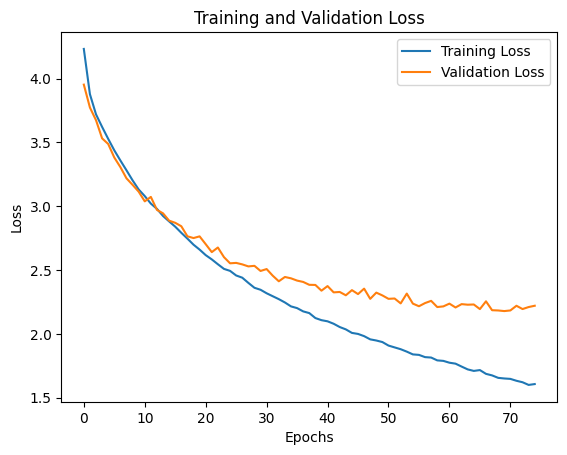

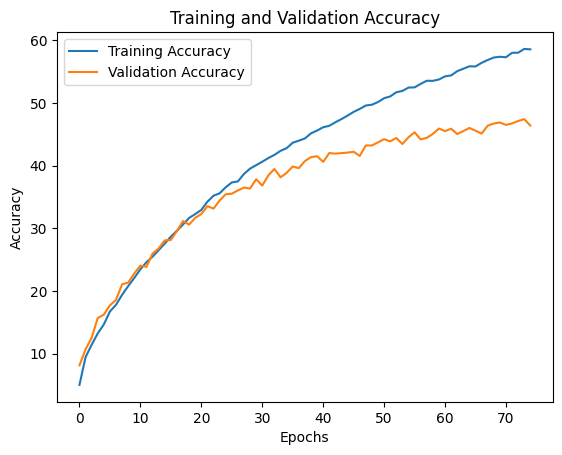

Epoch 1 duration: 0 hours, 0 minutes, 28 seconds
Epoch 2 duration: 0 hours, 0 minutes, 27 seconds
Epoch 3 duration: 0 hours, 0 minutes, 27 seconds
Epoch 4 duration: 0 hours, 0 minutes, 27 seconds
Epoch 5 duration: 0 hours, 0 minutes, 27 seconds
Epoch 6 duration: 0 hours, 0 minutes, 27 seconds
Epoch 7 duration: 0 hours, 0 minutes, 27 seconds
Epoch 8 duration: 0 hours, 0 minutes, 27 seconds
Epoch 9 duration: 0 hours, 0 minutes, 27 seconds
Epoch 10 duration: 0 hours, 0 minutes, 27 seconds
Epoch 11 duration: 0 hours, 0 minutes, 27 seconds
Epoch 12 duration: 0 hours, 0 minutes, 27 seconds
Epoch 13 duration: 0 hours, 0 minutes, 27 seconds
Epoch 14 duration: 0 hours, 0 minutes, 27 seconds
Epoch 15 duration: 0 hours, 0 minutes, 27 seconds
Epoch 16 duration: 0 hours, 0 minutes, 28 seconds
Epoch 17 duration: 0 hours, 0 minutes, 27 seconds
Epoch 18 duration: 0 hours, 0 minutes, 27 seconds
Epoch 19 duration: 0 hours, 0 minutes, 27 seconds
Epoch 20 duration: 0 hours, 0 minutes, 27 seconds
Epoch 21 

In [4]:
# Input jumlah epoch
jumlah_epoch = 200

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = VGG19(num_classes=100).to(device)
print(model)
summary(model, input_size=(3, 32, 32))

# DataParallel if more than one GPU is available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Function to print model parameter details
def print_parameter_details(model):
    for name, param in model.named_parameters():
        print(f"{name}: {param.size()} {'requires_grad' if param.requires_grad else 'frozen'}")

print_parameter_details(model)

# Define transformations for training and validation data
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_val)

# Split training set into train and validation sets
train_indices, val_indices = train_test_split(list(range(len(trainset))), test_size=0.2, stratify=trainset.targets)
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Define DataLoaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=val_sampler, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=100)

# Training function
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

# Validation function
def validate(model, val_loader, criterion, device, epoch):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            if batch_idx % 10 == 0:
                print(f'Validation Epoch: {epoch} [{batch_idx * len(inputs)}/{len(val_loader.dataset)} ({100. * batch_idx / len(val_loader):.0f}%)]\tLoss: {loss.item():.6f}')

            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    print(classification_report(all_labels, all_predictions))
    return val_loss / len(val_loader), accuracy

# Early stopping
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Timing variables
epoch_times = []
total_start_time = time.time()

# Function to convert seconds to hours, minutes, seconds
def convert_seconds(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return hours, minutes, seconds

for epoch in range(jumlah_epoch):
    epoch_start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device, epoch)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{jumlah_epoch}, Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%")
    scheduler.step(val_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_duration)
    hours, minutes, seconds = convert_seconds(epoch_duration)
    print(f"Epoch {epoch+1} duration: {hours} hours, {minutes} minutes, {seconds} seconds")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_weights_KAN.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

total_end_time = time.time()
total_duration = total_end_time - total_start_time
total_hours, total_minutes, total_seconds = convert_seconds(total_duration)
print(f"Total training time: {total_hours} hours, {total_minutes} minutes, {total_seconds} seconds")

model.load_state_dict(torch.load('best_model_weights_KAN.pth'))

# Evaluate model on test set
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    return accuracy, np.array(all_predictions), np.array(all_labels)

accuracy, preds, true_labels = test(model, test_loader, device)
print(f'Test Accuracy: {accuracy:.2f}%')

# Save predictions and labels for ROC plotting
np.save('preds_cifar100.npy', preds)
np.save('true_labels_cifar100.npy', true_labels)

# Plot training and validation loss
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Plot training and validation accuracy
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

for i, epoch_time in enumerate(epoch_times):
    hours, minutes, seconds = convert_seconds(epoch_time)
    print(f"Epoch {i+1} duration: {hours} hours, {minutes} minutes, {seconds} seconds")

/tmp/ipykernel_34/1985180903.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20').colors


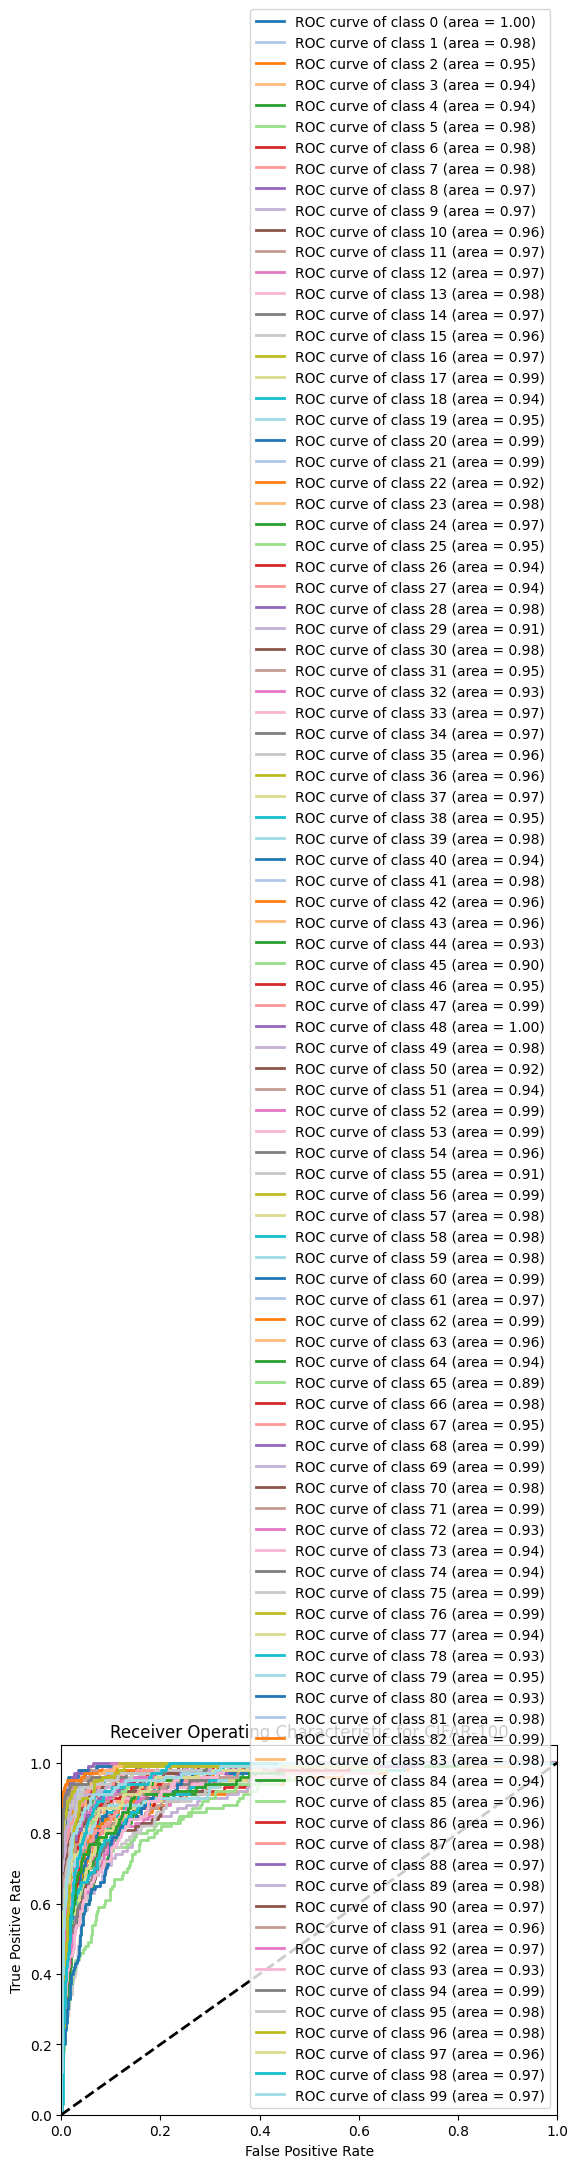

 
Accuracy: 0.5492
Precision: 0.5586
Recall: 0.5492
F1 Score: 0.5471
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.77      0.79      0.78       100
     Class 1       0.71      0.65      0.68       100
     Class 2       0.56      0.43      0.49       100
     Class 3       0.40      0.34      0.37       100
     Class 4       0.35      0.33      0.34       100
     Class 5       0.61      0.49      0.54       100
     Class 6       0.47      0.64      0.54       100
     Class 7       0.62      0.55      0.59       100
     Class 8       0.49      0.70      0.58       100
     Class 9       0.76      0.71      0.73       100
    Class 10       0.48      0.41      0.44       100
    Class 11       0.35      0.36      0.36       100
    Class 12       0.43      0.72      0.54       100
    Class 13       0.55      0.36      0.43       100
    Class 14       0.35      0.60      0.44       100
    Class 15       0.45      0.59      0.51

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize

# Load predictions and true labels
preds = np.load('preds_cifar100.npy')
true_labels = np.load('true_labels_cifar100.npy')

# Function to plot ROC curve for multi-class classification
def plot_roc_curve(true_labels, preds, n_classes):
    true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = plt.cm.get_cmap('tab20').colors
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i % 20], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for CIFAR-100')
    plt.legend(loc="lower right")
    plt.show()

# Function to calculate and print classification metrics for multi-class classification
def print_classification_metrics(true_labels, preds, n_classes):
    preds_labels = np.argmax(preds, axis=1)
    accuracy = accuracy_score(true_labels, preds_labels)
    precision = precision_score(true_labels, preds_labels, average='macro')
    recall = recall_score(true_labels, preds_labels, average='macro')
    f1 = f1_score(true_labels, preds_labels, average='macro')
    report = classification_report(true_labels, preds_labels, target_names=[f'Class {i}' for i in range(n_classes)])

    print(" ")
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Classification Report:')
    print(report)

# Plot ROC curve and print classification metrics
n_classes = 100
plot_roc_curve(true_labels, preds, n_classes)
print_classification_metrics(true_labels, preds, n_classes)
